# 🔬 Breast Cancer Wisconsin (Diagnostic) — Progetto di Machine Learning

**Corso:** Machine Learning / Data Science  
**Dataset:** Breast Cancer Wisconsin (Diagnostic) — UCI ML Repository (ID=17)  
**Obiettivo:** Classificazione binaria di tumori mammari (Maligno vs Benigno)  
**Autori:** [Inserire nomi del gruppo]  
**Data:** [Inserire data]

---

## 1. 📋 Introduction & Domain Description

### 1.1 Contesto Clinico

Il cancro al seno rappresenta una delle neoplasie più diffuse a livello mondiale e costituisce la prima causa di morte oncologica nella popolazione femminile. Secondo l'Organizzazione Mondiale della Sanità (OMS), nel 2020 sono stati diagnosticati circa 2,3 milioni di nuovi casi, rendendo la diagnosi precoce e accurata un fattore critico per la sopravvivenza delle pazienti.

La procedura diagnostica standard prevede l'agoaspirato con ago sottile (FNA — Fine Needle Aspirate) della massa mammaria, seguito dall'analisi citologica al microscopio delle cellule estratte. Il patologo valuta una serie di caratteristiche morfologiche dei nuclei cellulari per determinare se il tumore sia **benigno** (non invasivo) o **maligno** (potenzialmente metastatico).

### 1.2 Obiettivi del Progetto

Questo progetto si propone di:

1. **Esplorare e comprendere** le caratteristiche morfologiche dei nuclei cellulari presenti nel dataset
2. **Costruire modelli predittivi** in grado di classificare automaticamente i tumori come maligni o benigni
3. **Confrontare le performance** di diversi algoritmi di Machine Learning sul problema
4. **Identificare le feature più discriminanti** per la diagnosi
5. **Valutare l'affidabilità clinica** dei modelli sviluppati

### 1.3 Impatto Clinico e Considerazioni Etiche

Un sistema di supporto alla decisione clinica (CDSS) basato su ML può:
- Ridurre i tempi di diagnosi e i costi sanitari
- Fornire una "seconda opinione" oggettiva al patologo
- Migliorare l'accuratezza diagnostica, specialmente in contesti con risorse limitate

**Nota etica:** I modelli sviluppati in questo studio sono intesi come strumenti di supporto e non sostitutivi del giudizio medico. L'utilizzo clinico richiederebbe validazione su dataset indipendenti, certificazione e supervisione medica continua.

## 2. ⚙️ Setup & Importazione Librerie

In [1]:
# ============================================================
# INSTALLAZIONE DIPENDENZE
# ============================================================
!pip install ucimlrepo -q

In [2]:
# ============================================================
# IMPORTAZIONE LIBRERIE
# ============================================================

# Librerie fondamentali
import numpy as np
import pandas as pd

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset
from ucimlrepo import fetch_ucirepo

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    GridSearchCV, RandomizedSearchCV
)

# Modelli supervisionati
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Modelli non supervisionati
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Metriche di valutazione
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    silhouette_score, adjusted_rand_score
)

# Utility
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# CONFIGURAZIONE GLOBALE
# ============================================================
RANDOM_STATE = 42  # Per la riproducibilità

# Stile dei grafici — publication-ready
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})
sns.set_style('whitegrid')
sns.set_palette('colorblind')

print("✅ Tutte le librerie sono state importate correttamente.")
print(f"   NumPy: {np.__version__}")
print(f"   Pandas: {pd.__version__}")
print(f"   Random State: {RANDOM_STATE}")

✅ Tutte le librerie sono state importate correttamente.
   NumPy: 2.0.2
   Pandas: 2.2.2
   Random State: 42


## 3. 📦 Caricamento Dataset

In [3]:
# ============================================================
# CARICAMENTO DEL DATASET DA UCI REPOSITORY
# ============================================================

# Fetch del dataset Breast Cancer Wisconsin (Diagnostic)
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Estrazione features e target come pandas DataFrames
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# Stampa informazioni generali sul dataset
print("=" * 60)
print("DATASET: Breast Cancer Wisconsin (Diagnostic)")
print("=" * 60)
print(f"Numero di campioni:  {X.shape[0]}")
print(f"Numero di feature:   {X.shape[1]}")
print(f"Classi target:       {y.iloc[:, 0].unique()}")
print(f"\nNomi delle feature:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

DATASET: Breast Cancer Wisconsin (Diagnostic)
Numero di campioni:  569
Numero di feature:   30
Classi target:       ['M' 'B']

Nomi delle feature:
   1. radius1
   2. texture1
   3. perimeter1
   4. area1
   5. smoothness1
   6. compactness1
   7. concavity1
   8. concave_points1
   9. symmetry1
  10. fractal_dimension1
  11. radius2
  12. texture2
  13. perimeter2
  14. area2
  15. smoothness2
  16. compactness2
  17. concavity2
  18. concave_points2
  19. symmetry2
  20. fractal_dimension2
  21. radius3
  22. texture3
  23. perimeter3
  24. area3
  25. smoothness3
  26. compactness3
  27. concavity3
  28. concave_points3
  29. symmetry3
  30. fractal_dimension3


In [4]:
# ============================================================
# PREPARAZIONE INIZIALE DEI DATI
# ============================================================

# Unifichiamo in un unico DataFrame per comodità nell'EDA
df = X.copy()
df['Diagnosi'] = y.iloc[:, 0]

# Codifica del target: M (Maligno) = 1, B (Benigno) = 0
le = LabelEncoder()
y_encoded = le.fit_transform(y.iloc[:, 0])
df['Diagnosi_num'] = y_encoded

# Mapping per le etichette
LABEL_MAP = {0: 'Benigno (B)', 1: 'Maligno (M)'}
COLORS = {0: '#2196F3', 1: '#F44336'}  # Blu = Benigno, Rosso = Maligno

print("Codifica del target:")
print(f"  B (Benigno)  → 0")
print(f"  M (Maligno)  → 1")
print(f"\nPrime 5 righe del dataset:")
df.head()

Codifica del target:
  B (Benigno)  → 0
  M (Maligno)  → 1

Prime 5 righe del dataset:


,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosi,Diagnosi_num
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M,1


## 4. 📐 Dataset Design & Assumptions

### 4.1 Descrizione delle Feature

Le 30 feature del dataset sono calcolate a partire da immagini digitalizzate di agoaspirati con ago sottile (FNA) di masse mammarie. Ogni feature descrive una caratteristica dei nuclei cellulari presenti nell'immagine.

Per ciascuna delle **10 caratteristiche base** vengono calcolati tre valori statistici:
- **Mean** (media): valore medio su tutti i nuclei dell'immagine
- **SE** (standard error): errore standard della misura
- **Worst** (peggiore): media dei tre valori più estremi

Le 10 caratteristiche base sono:

| # | Feature | Descrizione |
|---|---------|-------------|
| 1 | **Radius** | Distanza media dal centro ai punti del perimetro |
| 2 | **Texture** | Deviazione standard dei valori di grigio |
| 3 | **Perimeter** | Perimetro del nucleo cellulare |
| 4 | **Area** | Area del nucleo cellulare |
| 5 | **Smoothness** | Variazione locale nelle lunghezze dei raggi |
| 6 | **Compactness** | (Perimetro² / Area) - 1.0 |
| 7 | **Concavity** | Severità delle porzioni concave del contorno |
| 8 | **Concave points** | Numero di porzioni concave del contorno |
| 9 | **Symmetry** | Simmetria del nucleo |
| 10 | **Fractal dimension** | "Coastline approximation" - 1 |

### 4.2 Assunzioni e Ipotesi

1. **Separabilità delle classi:** Si ipotizza che le caratteristiche morfologiche dei nuclei cellulari siano sufficientemente discriminanti per distinguere tumori maligni da benigni
2. **Indipendenza dei campioni:** Ogni campione rappresenta un paziente distinto
3. **Rappresentatività:** Il dataset è rappresentativo della popolazione di riferimento
4. **Qualità dei dati:** Le misurazioni sono state effettuate con metodologia standardizzata

### 4.3 Limitazioni Note

- Il dataset proviene da un singolo centro clinico (Università del Wisconsin)
- Non sono disponibili informazioni demografiche (età, etnia, storia familiare)
- La dimensione del campione, pur adeguata, è limitata (569 osservazioni)
- Possibile presenza di correlazioni spurie tra feature derivate dalla stessa misura base

In [5]:
# ============================================================
# VERIFICA QUALITÀ DEI DATI
# ============================================================

print("=" * 60)
print("CONTROLLO QUALITÀ DEI DATI")
print("=" * 60)

# Valori mancanti
missing = X.isnull().sum()
print(f"\n📌 Valori mancanti per feature:")
if missing.sum() == 0:
    print("   Nessun valore mancante rilevato ✅")
else:
    print(missing[missing > 0])

# Valori duplicati
duplicati = X.duplicated().sum()
print(f"\n📌 Righe duplicate: {duplicati}")

# Tipi di dato
print(f"\n📌 Tipi di dato:")
print(X.dtypes.value_counts())

# Info generali
print(f"\n📌 Shape del dataset: {X.shape}")

CONTROLLO QUALITÀ DEI DATI

📌 Valori mancanti per feature:
   Nessun valore mancante rilevato ✅

📌 Righe duplicate: 0

📌 Tipi di dato:
float64    30
Name: count, dtype: int64

📌 Shape del dataset: (569, 30)


## 5. 📊 Exploratory Data Analysis (EDA)

### 5.1 Statistiche Descrittive

In [6]:
# ============================================================
# STATISTICHE DESCRITTIVE COMPLETE
# ============================================================

# Statistiche generali
stats_df = X.describe().T
stats_df.columns = ['Conteggio', 'Media', 'Dev. Std.', 'Min', '25%', '50%', '75%', 'Max']
stats_df['Range'] = stats_df['Max'] - stats_df['Min']
stats_df['CV (%)'] = (stats_df['Dev. Std.'] / stats_df['Media'] * 100).round(2)

print("=" * 60)
print("STATISTICHE DESCRITTIVE")
print("=" * 60)
display(stats_df.round(4))

STATISTICHE DESCRITTIVE


,Conteggio,Media,Dev. Std.,Min,25%,50%,75%,Max,Range,CV (%)
radius1,569.0,14.1273,3.5240,6.9810,11.7000,13.3700,15.7800,28.1100,21.1290,24.94
texture1,569.0,19.2896,4.3010,9.7100,16.1700,18.8400,21.8000,39.2800,29.5700,22.30
perimeter1,569.0,91.9690,24.2990,43.7900,75.1700,86.2400,104.1000,188.5000,144.7100,26.42
area1,569.0,654.8891,351.9141,143.5000,420.3000,551.1000,782.7000,2501.0000,2357.5000,53.74
smoothness1,569.0,0.0964,0.0141,0.0526,0.0864,0.0959,0.1053,0.1634,0.1108,14.60
compactness1,569.0,0.1043,0.0528,0.0194,0.0649,0.0926,0.1304,0.3454,0.3260,50.62
concavity1,569.0,0.0888,0.0797,0.0000,0.0296,0.0615,0.1307,0.4268,0.4268,89.78
concave_points1,569.0,0.0489,0.0388,0.0000,0.0203,0.0335,0.0740,0.2012,0.2012,79.32
symmetry1,569.0,0.1812,0.0274,0.1060,0.1619,0.1792,0.1957,0.3040,0.1980,15.13
fractal_dimension1,569.0,0.0628,0.0071,0.0500,0.0577,0.0615,0.0661,0.0974,0.0475,11.24


In [7]:
# ============================================================
# STATISTICHE PER CLASSE
# ============================================================

# Selezioniamo le feature "mean" per una vista sintetica
mean_features = [col for col in X.columns if 'mean' in col.lower() or
                 (not any(s in col.lower() for s in ['se', 'worst']))]
# Prendiamo le prime 10 feature (le medie)
mean_cols = list(X.columns[:10])

print("=" * 60)
print("CONFRONTO STATISTICHE PER CLASSE (Feature Mean)")
print("=" * 60)

for classe in ['B', 'M']:
    label = 'Benigno' if classe == 'B' else 'Maligno'
    mask = df['Diagnosi'] == classe
    print(f"\n--- {label} (n={mask.sum()}) ---")
    display(df.loc[mask, mean_cols].describe().T[['mean', 'std', 'min', 'max']].round(4))

CONFRONTO STATISTICHE PER CLASSE (Feature Mean)

--- Benigno (n=357) ---


,mean,std,min,max
radius1,12.1465,1.7805,6.9810,17.8500
texture1,17.9148,3.9951,9.7100,33.8100
perimeter1,78.0754,11.8074,43.7900,114.6000
area1,462.7902,134.2871,143.5000,992.1000
smoothness1,0.0925,0.0134,0.0526,0.1634
compactness1,0.0801,0.0337,0.0194,0.2239
concavity1,0.0461,0.0434,0.0000,0.4108
concave_points1,0.0257,0.0159,0.0000,0.0853
symmetry1,0.1742,0.0248,0.1060,0.2743
fractal_dimension1,0.0629,0.0067,0.0518,0.0958



--- Maligno (n=212) ---


,mean,std,min,max
radius1,17.4628,3.2040,10.9500,28.1100
texture1,21.6049,3.7795,10.3800,39.2800
perimeter1,115.3654,21.8547,71.9000,188.5000
area1,978.3764,367.9380,361.6000,2501.0000
smoothness1,0.1029,0.0126,0.0737,0.1447
compactness1,0.1452,0.0540,0.0460,0.3454
concavity1,0.1608,0.0750,0.0240,0.4268
concave_points1,0.0880,0.0344,0.0203,0.2012
symmetry1,0.1929,0.0276,0.1308,0.3040
fractal_dimension1,0.0627,0.0076,0.0500,0.0974


### 5.2 Distribuzione delle Classi

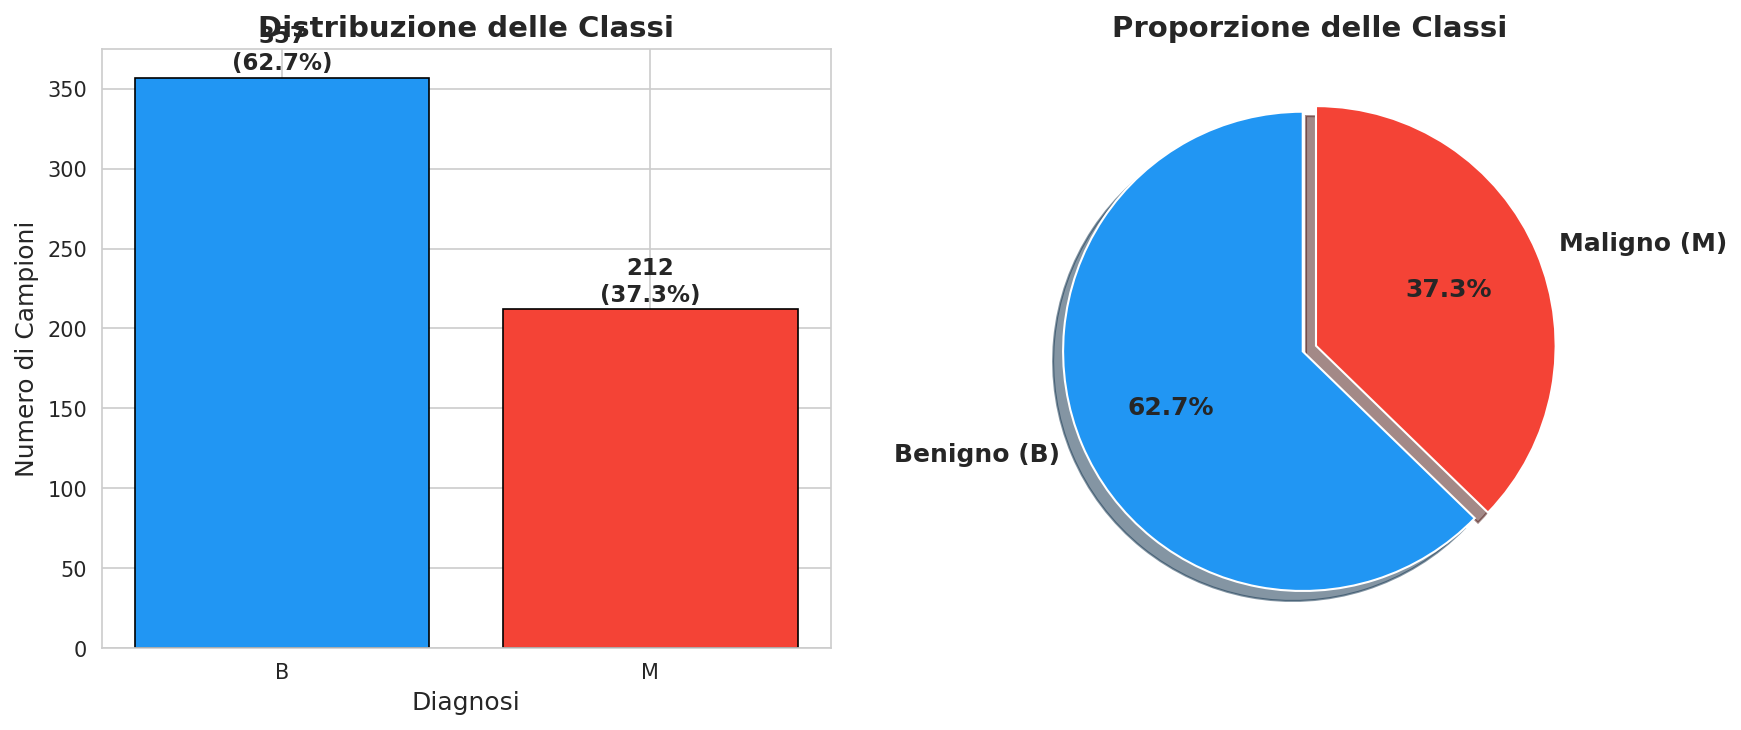


Rapporto di bilanciamento (min/max): 0.594
Le classi sono bilanciate (soglia convenzionale: 0.5)


In [8]:
# ============================================================
# DISTRIBUZIONE DELLE CLASSI
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Conteggio
class_counts = df['Diagnosi'].value_counts()
colors_list = ['#2196F3', '#F44336']

axes[0].bar(class_counts.index, class_counts.values, color=colors_list,
            edgecolor='black', linewidth=0.8)
axes[0].set_title('Distribuzione delle Classi', fontweight='bold')
axes[0].set_xlabel('Diagnosi')
axes[0].set_ylabel('Numero di Campioni')
for i, (idx, val) in enumerate(zip(class_counts.index, class_counts.values)):
    axes[0].text(i, val + 5, f'{val}\n({val/len(df)*100:.1f}%)',
                ha='center', fontweight='bold', fontsize=11)

# Grafico a torta
axes[1].pie(class_counts.values, labels=['Benigno (B)', 'Maligno (M)'],
            colors=colors_list, autopct='%1.1f%%', startangle=90,
            explode=(0.03, 0.03), shadow=True,
            textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Proporzione delle Classi', fontweight='bold')

plt.tight_layout()
plt.savefig('distribuzione_classi.png', dpi=300, bbox_inches='tight')
plt.show()

# Rapporto di bilanciamento
ratio = class_counts.min() / class_counts.max()
print(f"\nRapporto di bilanciamento (min/max): {ratio:.3f}")
print(f"Le classi sono {'bilanciate' if ratio > 0.5 else 'sbilanciate'} "
      f"(soglia convenzionale: 0.5)")

### 5.3 Distribuzione delle Feature

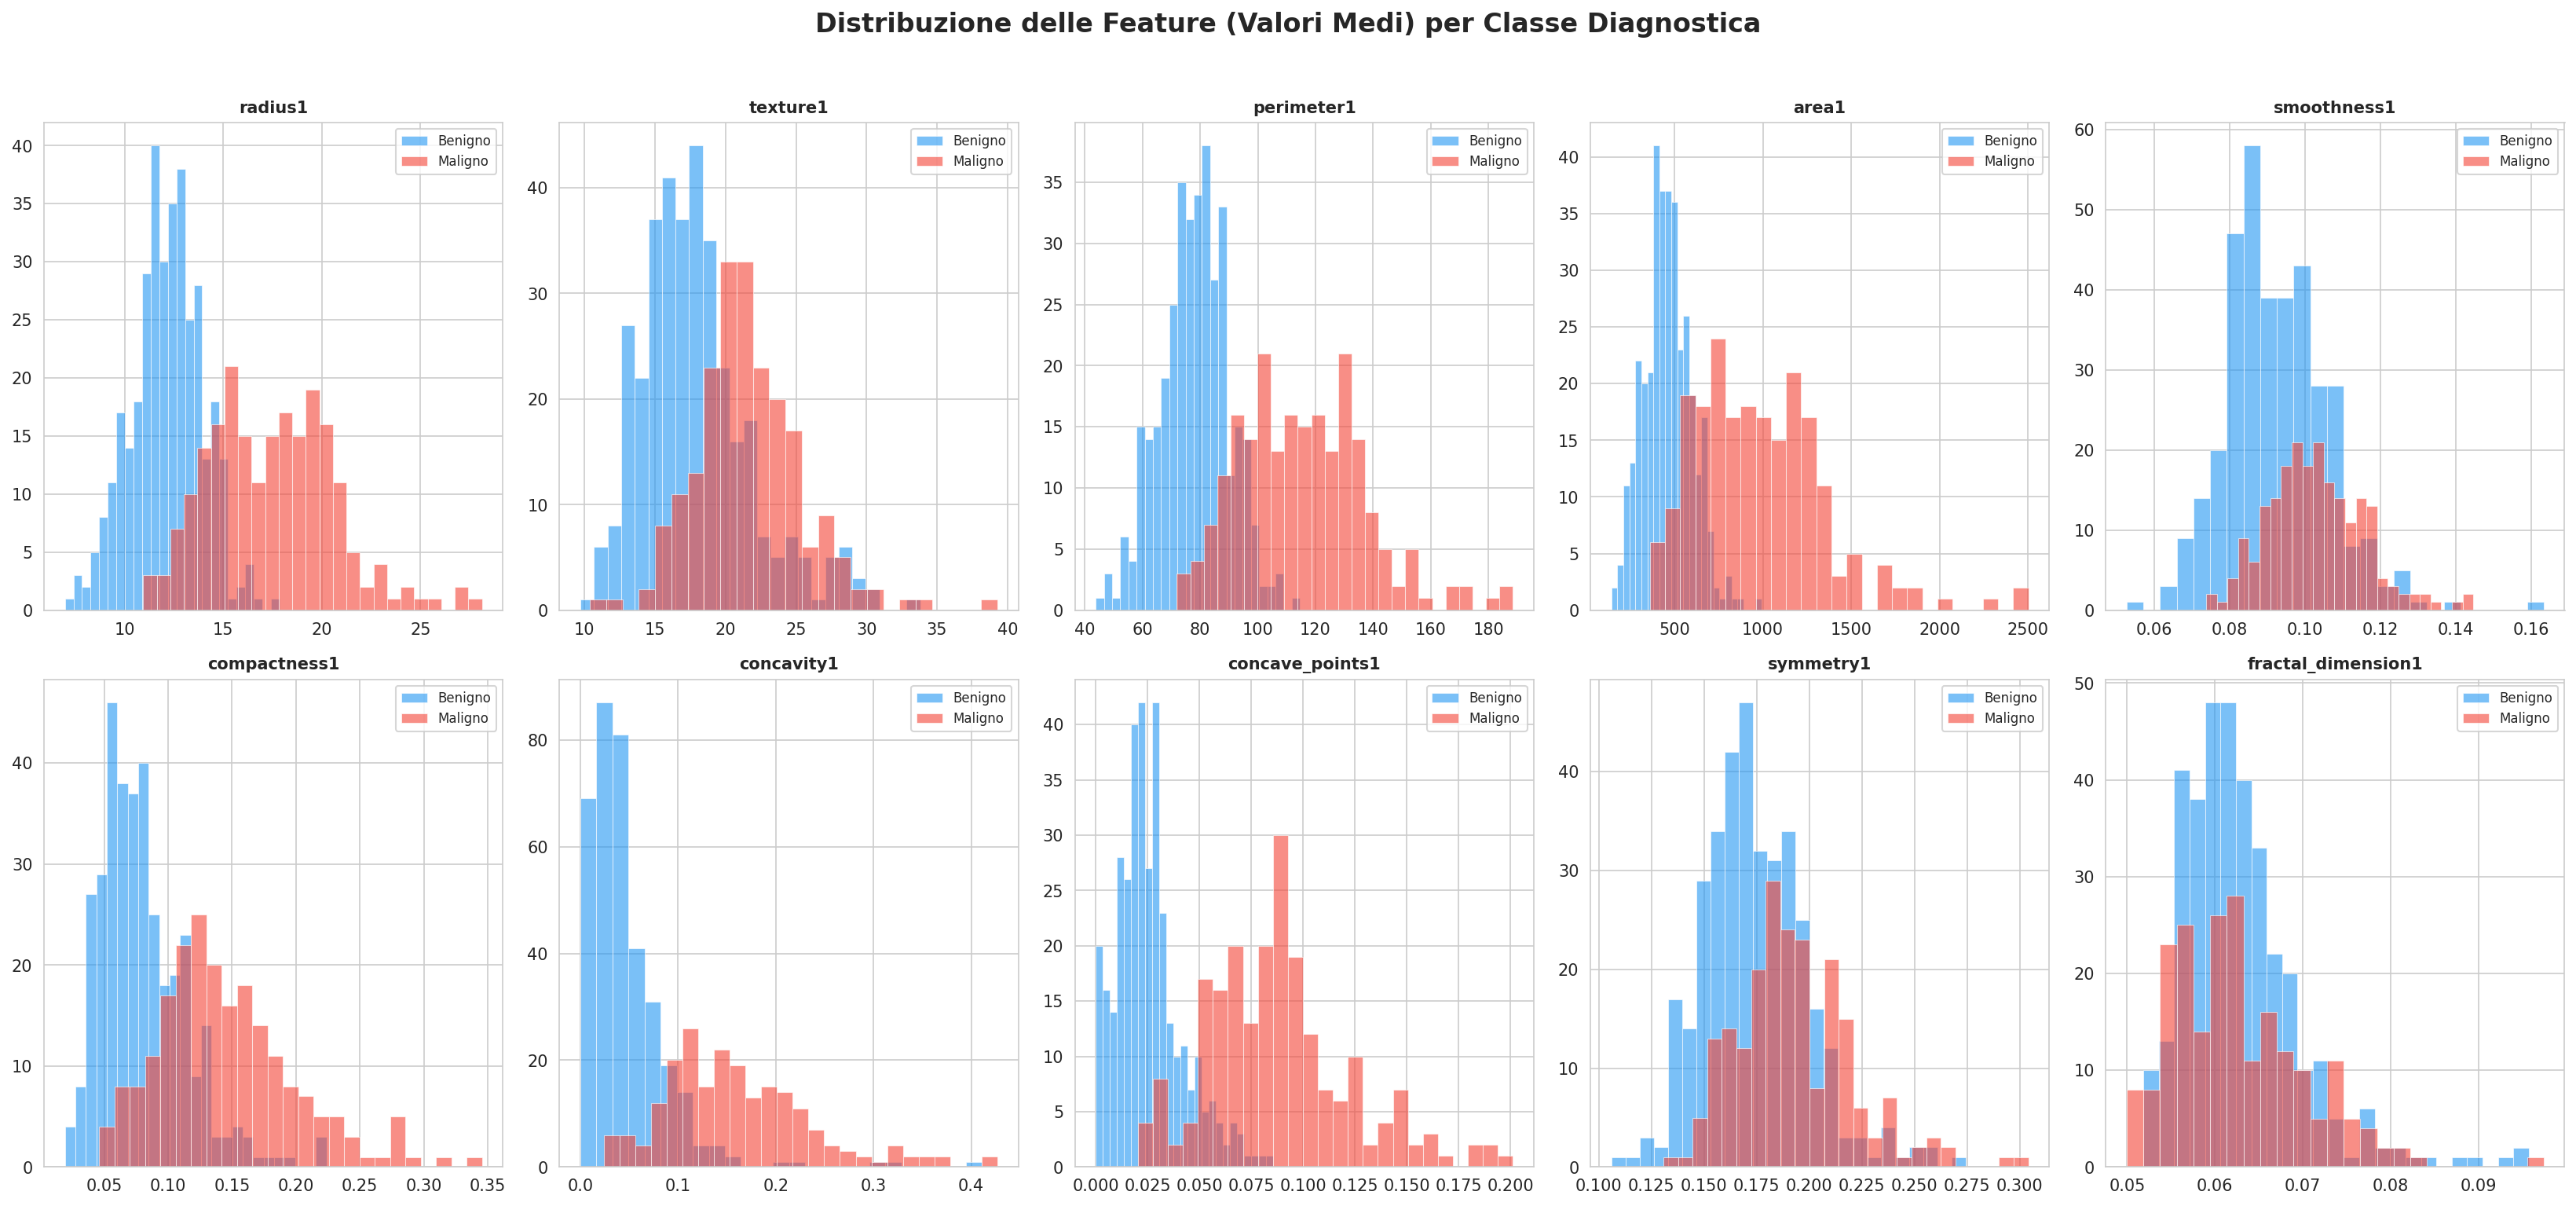

In [9]:
# ============================================================
# DISTRIBUZIONE DELLE FEATURE (Mean) PER CLASSE
# ============================================================

mean_cols = list(X.columns[:10])  # Le prime 10 feature (valori medi)

fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.ravel()

for i, col in enumerate(mean_cols):
    for classe, color, label in [('B', '#2196F3', 'Benigno'),
                                   ('M', '#F44336', 'Maligno')]:
        data = df[df['Diagnosi'] == classe][col]
        axes[i].hist(data, bins=25, alpha=0.6, color=color, label=label,
                     edgecolor='white', linewidth=0.5)

    axes[i].set_title(col, fontweight='bold', fontsize=10)
    axes[i].set_xlabel('')
    axes[i].legend(fontsize=8)

fig.suptitle('Distribuzione delle Feature (Valori Medi) per Classe Diagnostica',
             fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('distribuzioni_feature_mean.png', dpi=300, bbox_inches='tight')
plt.show()

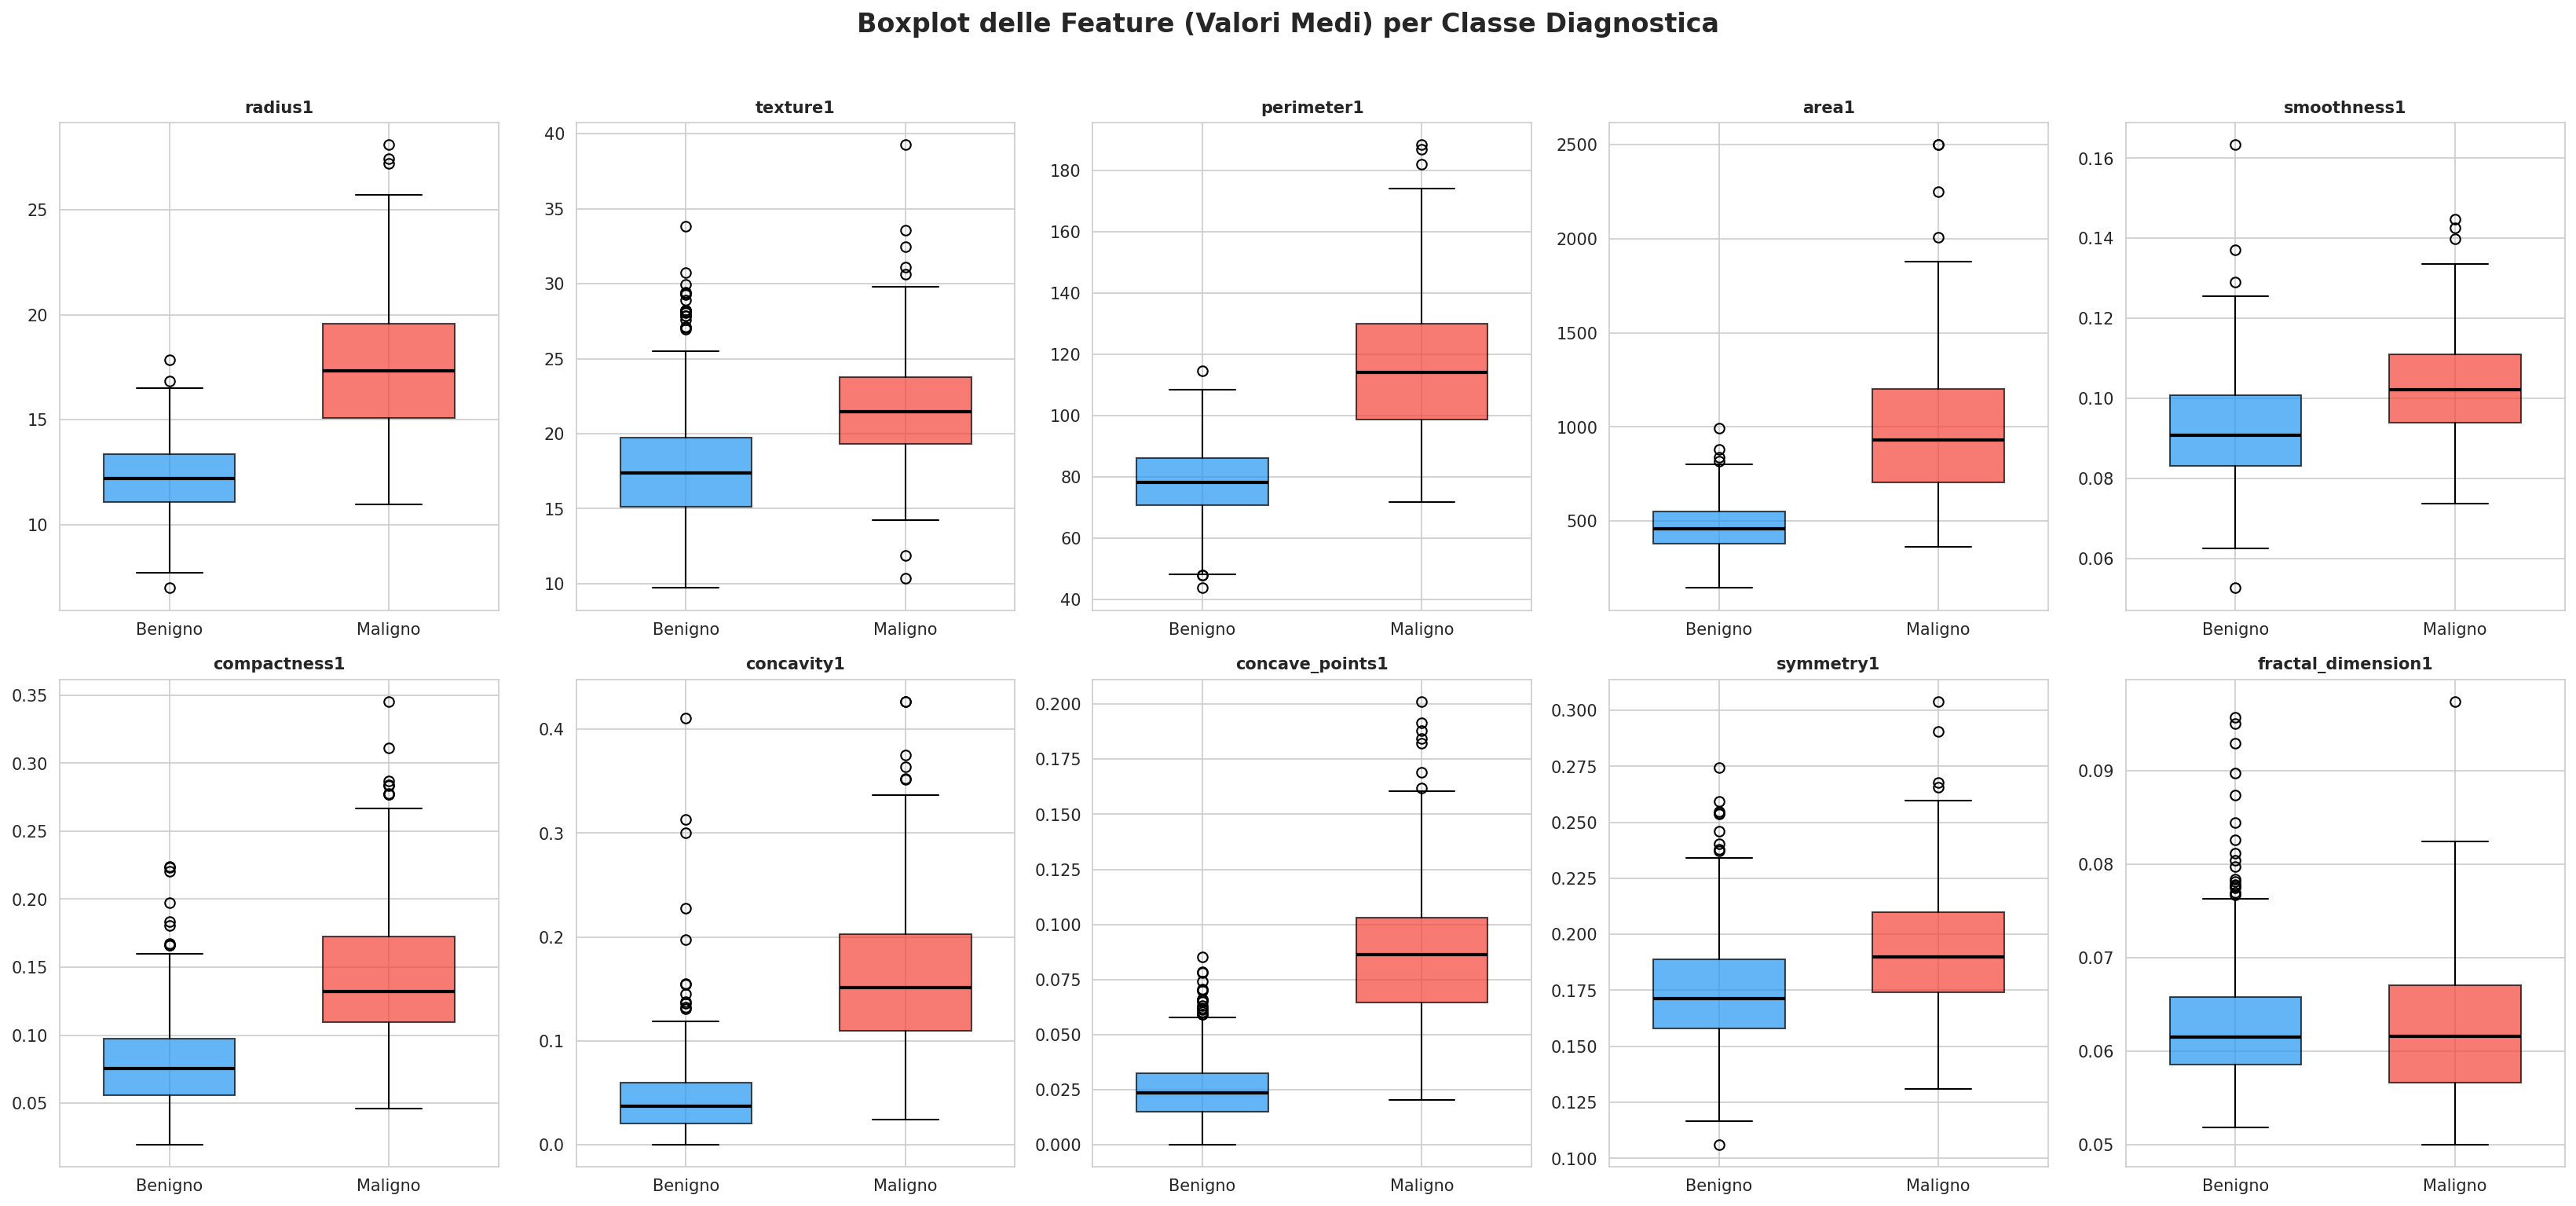

In [10]:
# ============================================================
# BOXPLOT COMPARATIVI PER CLASSE
# ============================================================

fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.ravel()

for i, col in enumerate(mean_cols):
    data_b = df[df['Diagnosi'] == 'B'][col]
    data_m = df[df['Diagnosi'] == 'M'][col]

    bp = axes[i].boxplot([data_b, data_m], labels=['Benigno', 'Maligno'],
                         patch_artist=True, widths=0.6,
                         medianprops=dict(color='black', linewidth=2))

    bp['boxes'][0].set_facecolor('#2196F3')
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_facecolor('#F44336')
    bp['boxes'][1].set_alpha(0.7)

    axes[i].set_title(col, fontweight='bold', fontsize=10)

fig.suptitle('Boxplot delle Feature (Valori Medi) per Classe Diagnostica',
             fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('boxplot_feature_mean.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.4 Analisi delle Correlazioni

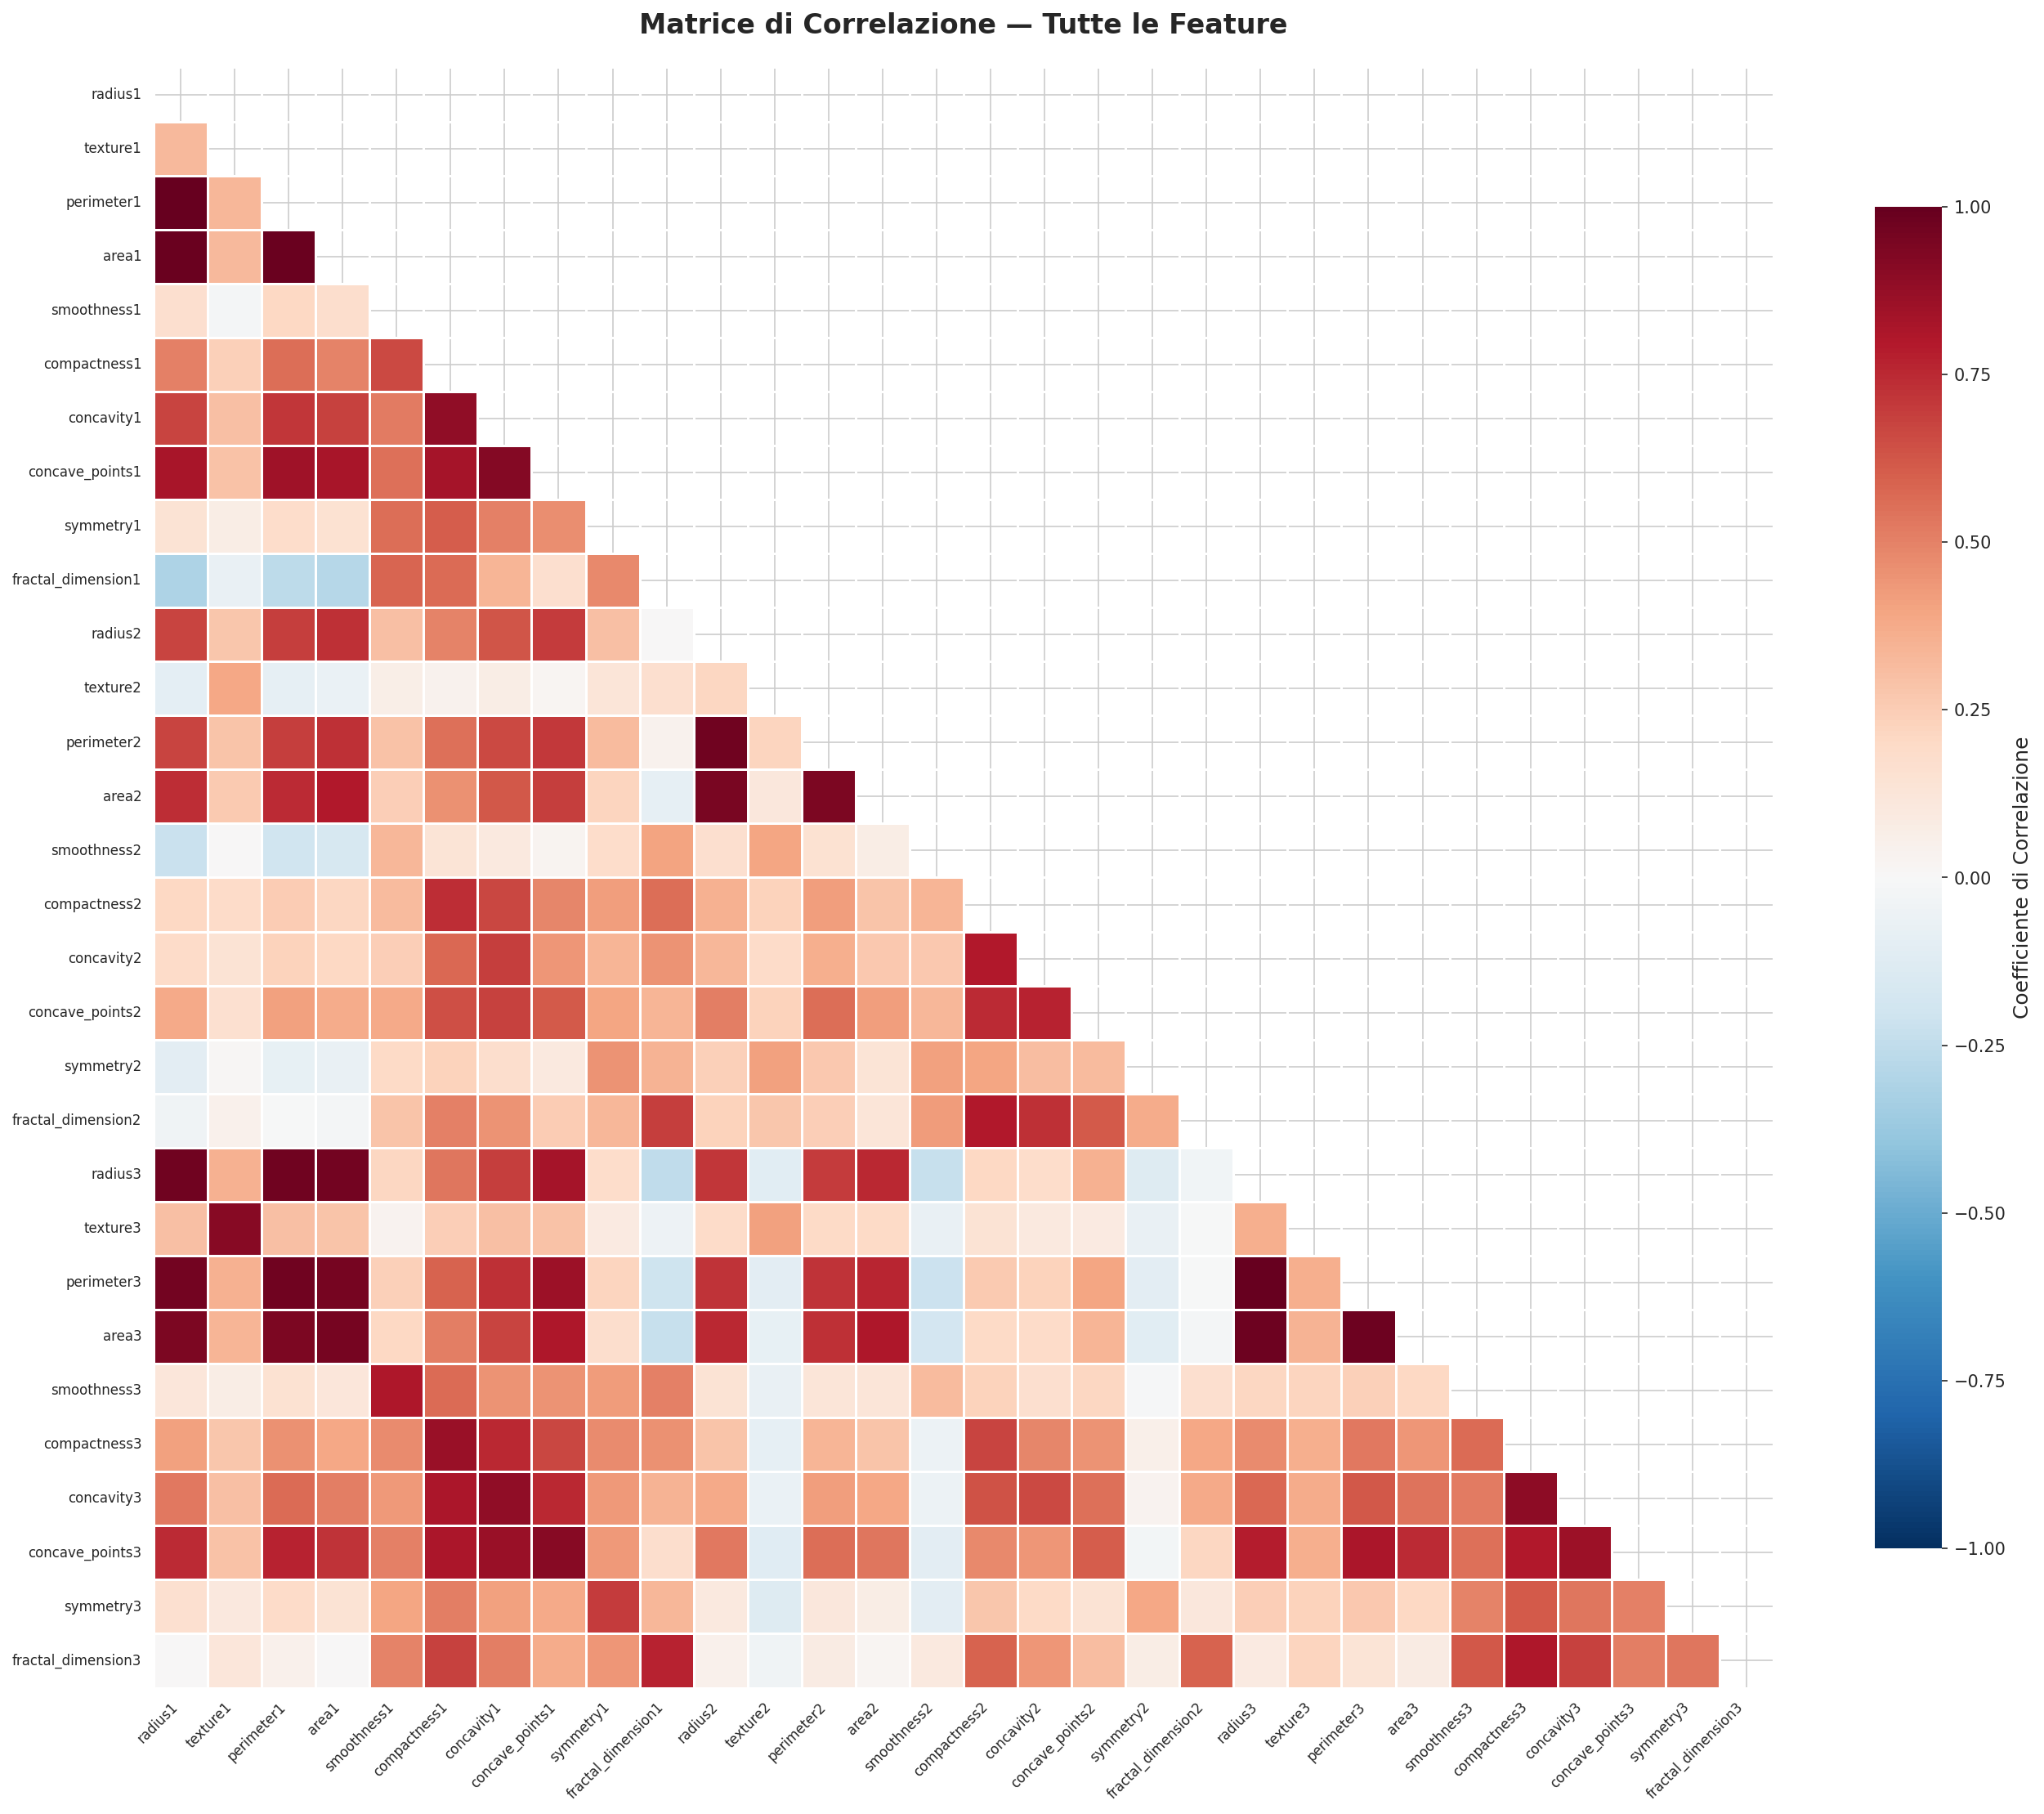


TOP 10 COPPIE DI FEATURE PIÙ CORRELATE


,Feature 1,Feature 2,|Correlazione|,Correlazione
0,perimeter1,radius1,0.997855,0.997855
1,perimeter3,radius3,0.993708,0.993708
2,area1,radius1,0.987357,0.987357
3,area1,perimeter1,0.986507,0.986507
4,area3,radius3,0.984015,0.984015
5,area3,perimeter3,0.977578,0.977578
6,perimeter2,radius2,0.972794,0.972794
7,perimeter3,perimeter1,0.970387,0.970387
8,radius3,radius1,0.969539,0.969539
9,radius3,perimeter1,0.969476,0.969476


In [11]:
# ============================================================
# MATRICE DI CORRELAZIONE
# ============================================================

# Correlazione tra tutte le feature
corr_matrix = X.corr()

# Heatmap completa
fig, ax = plt.subplots(figsize=(18, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True,
            linewidths=0.5, cbar_kws={'shrink': 0.8, 'label': 'Coefficiente di Correlazione'},
            ax=ax)
ax.set_title('Matrice di Correlazione — Tutte le Feature',
             fontweight='bold', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('matrice_correlazione.png', dpi=300, bbox_inches='tight')
plt.show()

# Identificazione delle coppie più correlate
print("\n" + "=" * 60)
print("TOP 10 COPPIE DI FEATURE PIÙ CORRELATE")
print("=" * 60)

# Estrai le correlazioni uniche (triangolo superiore)
upper_tri = corr_matrix.where(mask.T)
corr_pairs = []
for col in upper_tri.columns:
    for idx in upper_tri.index:
        val = upper_tri.loc[idx, col]
        if pd.notna(val) and idx != col:
            corr_pairs.append((idx, col, abs(val), val))

corr_pairs_df = pd.DataFrame(corr_pairs,
                             columns=['Feature 1', 'Feature 2', '|Correlazione|', 'Correlazione'])
corr_pairs_df = corr_pairs_df.sort_values('|Correlazione|', ascending=False).head(10)
display(corr_pairs_df.reset_index(drop=True))

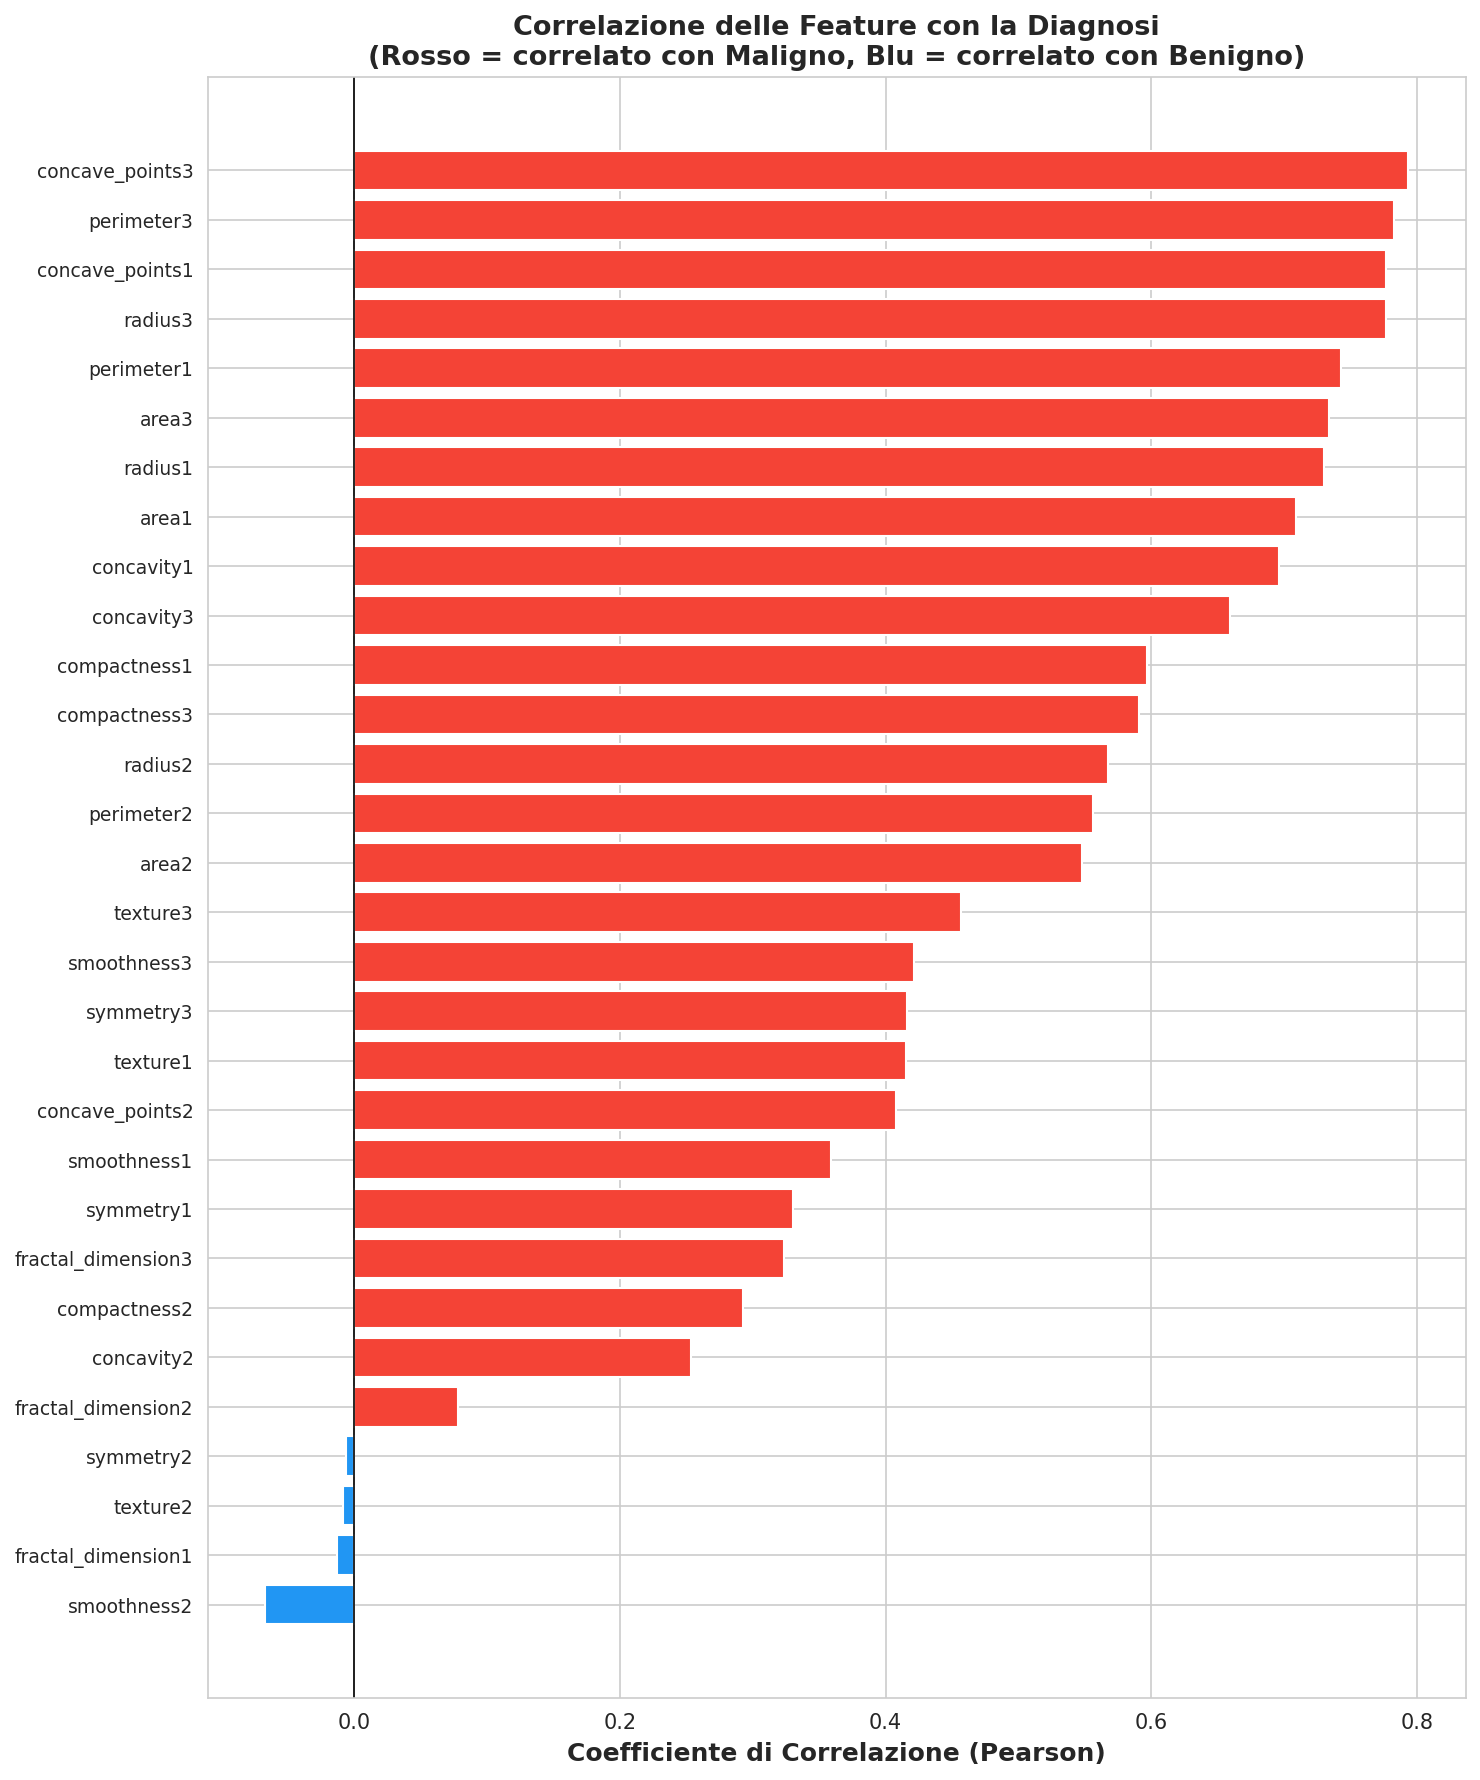


Le 5 feature più positivamente correlate con diagnosi maligna:
  concave_points3: 0.7936
  perimeter3: 0.7829
  concave_points1: 0.7766
  radius3: 0.7765
  perimeter1: 0.7426

Le 5 feature meno correlate (o negativamente correlate):
  fractal_dimension2: 0.0780
  symmetry2: -0.0065
  texture2: -0.0083
  fractal_dimension1: -0.0128
  smoothness2: -0.0670


In [12]:
# ============================================================
# CORRELAZIONE CON IL TARGET
# ============================================================

# Correlazione di ogni feature con la diagnosi
corr_target = X.corrwith(pd.Series(y_encoded, index=X.index)).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 12))
colors = ['#F44336' if v > 0 else '#2196F3' for v in corr_target.values]
ax.barh(range(len(corr_target)), corr_target.values, color=colors, edgecolor='white')
ax.set_yticks(range(len(corr_target)))
ax.set_yticklabels(corr_target.index, fontsize=9)
ax.set_xlabel('Coefficiente di Correlazione (Pearson)', fontweight='bold')
ax.set_title('Correlazione delle Feature con la Diagnosi\n(Rosso = correlato con Maligno, Blu = correlato con Benigno)',
             fontweight='bold', fontsize=13)
ax.axvline(x=0, color='black', linewidth=0.8)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('correlazione_target.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLe 5 feature più positivamente correlate con diagnosi maligna:")
for feat, val in corr_target.head(5).items():
    print(f"  {feat}: {val:.4f}")

print("\nLe 5 feature meno correlate (o negativamente correlate):")
for feat, val in corr_target.tail(5).items():
    print(f"  {feat}: {val:.4f}")

### 5.5 Identificazione degli Outlier

ANALISI OUTLIER (metodo IQR, k=1.5)


,Feature,N. Outlier,% Outlier
0,area2,65,11.42
1,radius2,38,6.68
2,perimeter2,38,6.68
3,area3,35,6.15
4,smoothness2,30,5.27
5,fractal_dimension2,28,4.92
6,compactness2,28,4.92
7,symmetry2,27,4.75
8,area1,25,4.39
9,fractal_dimension3,24,4.22


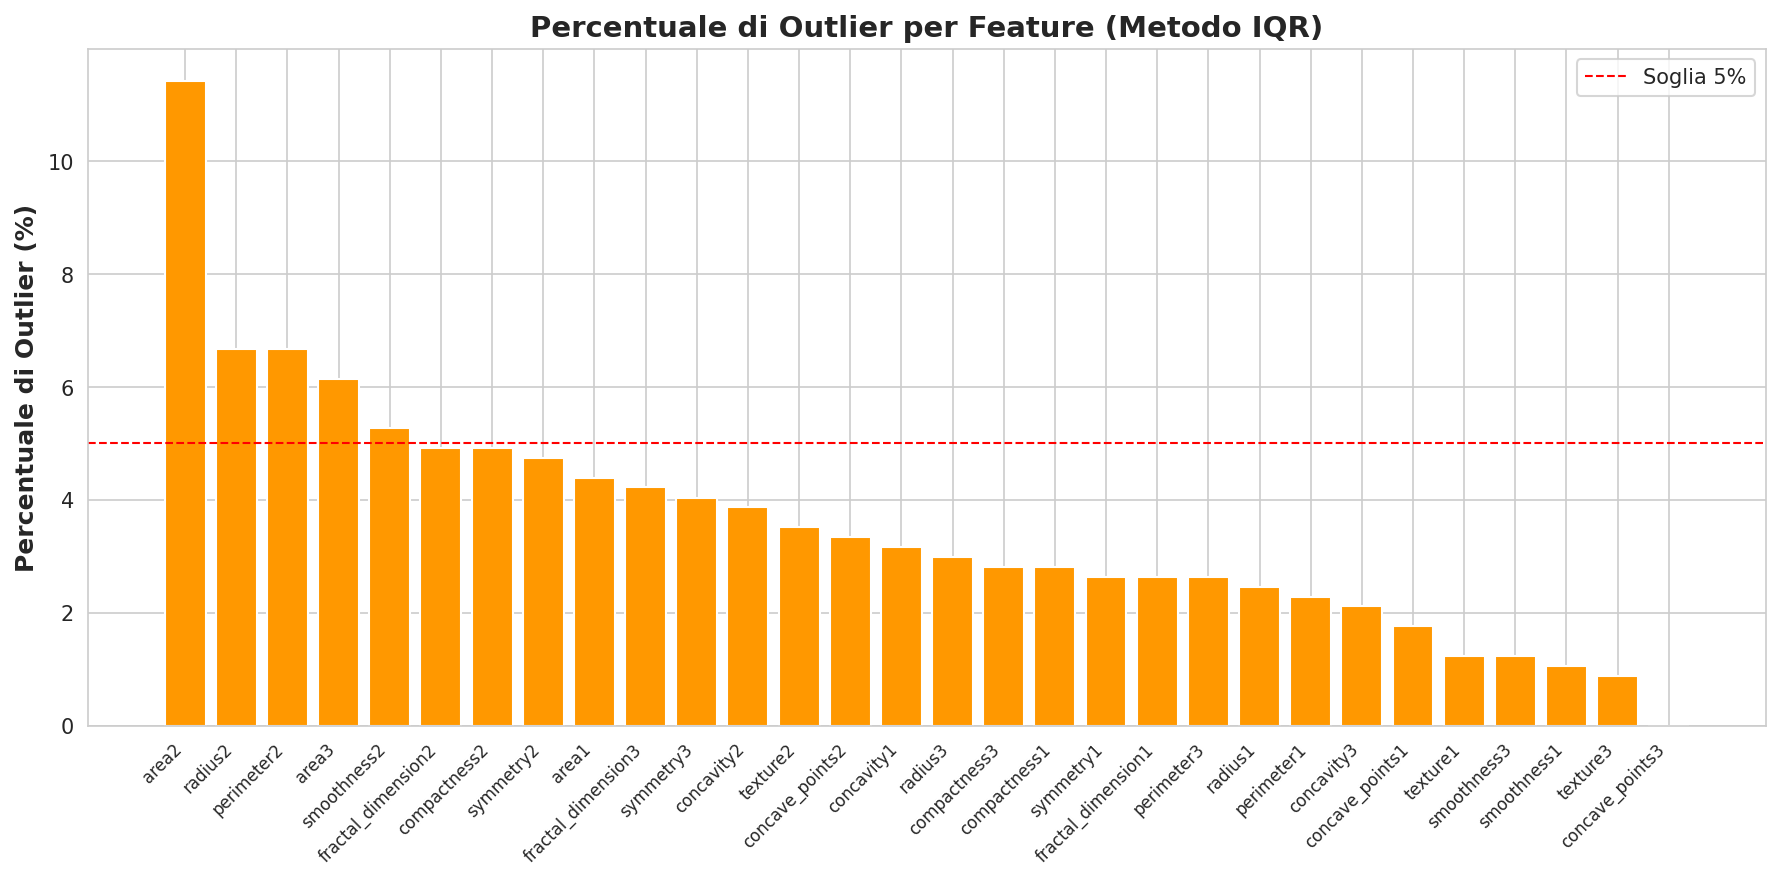


📌 Nota: Gli outlier non vengono rimossi poiché nel contesto medico
   i valori estremi possono essere clinicamente significativi.


In [13]:
# ============================================================
# ANALISI OUTLIER CON METODO IQR
# ============================================================

def conta_outlier_iqr(data, k=1.5):
    """Conta gli outlier usando il metodo IQR."""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return ((data < lower) | (data > upper)).sum()

outlier_counts = X.apply(conta_outlier_iqr)
outlier_df = pd.DataFrame({
    'Feature': outlier_counts.index,
    'N. Outlier': outlier_counts.values,
    '% Outlier': (outlier_counts.values / len(X) * 100).round(2)
}).sort_values('N. Outlier', ascending=False)

print("=" * 60)
print("ANALISI OUTLIER (metodo IQR, k=1.5)")
print("=" * 60)
display(outlier_df.reset_index(drop=True))

# Visualizzazione
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(range(len(outlier_df)), outlier_df['% Outlier'].values,
       color='#FF9800', edgecolor='white')
ax.set_xticks(range(len(outlier_df)))
ax.set_xticklabels(outlier_df['Feature'].values, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Percentuale di Outlier (%)', fontweight='bold')
ax.set_title('Percentuale di Outlier per Feature (Metodo IQR)',
             fontweight='bold')
ax.axhline(y=5, color='red', linestyle='--', linewidth=1, label='Soglia 5%')
ax.legend()
plt.tight_layout()
plt.savefig('outlier_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📌 Nota: Gli outlier non vengono rimossi poiché nel contesto medico")
print(f"   i valori estremi possono essere clinicamente significativi.")

### 5.6 Pairplot delle Feature Principali

Feature selezionate per il pairplot: ['concave_points3', 'perimeter3', 'concave_points1', 'radius3', 'perimeter1']


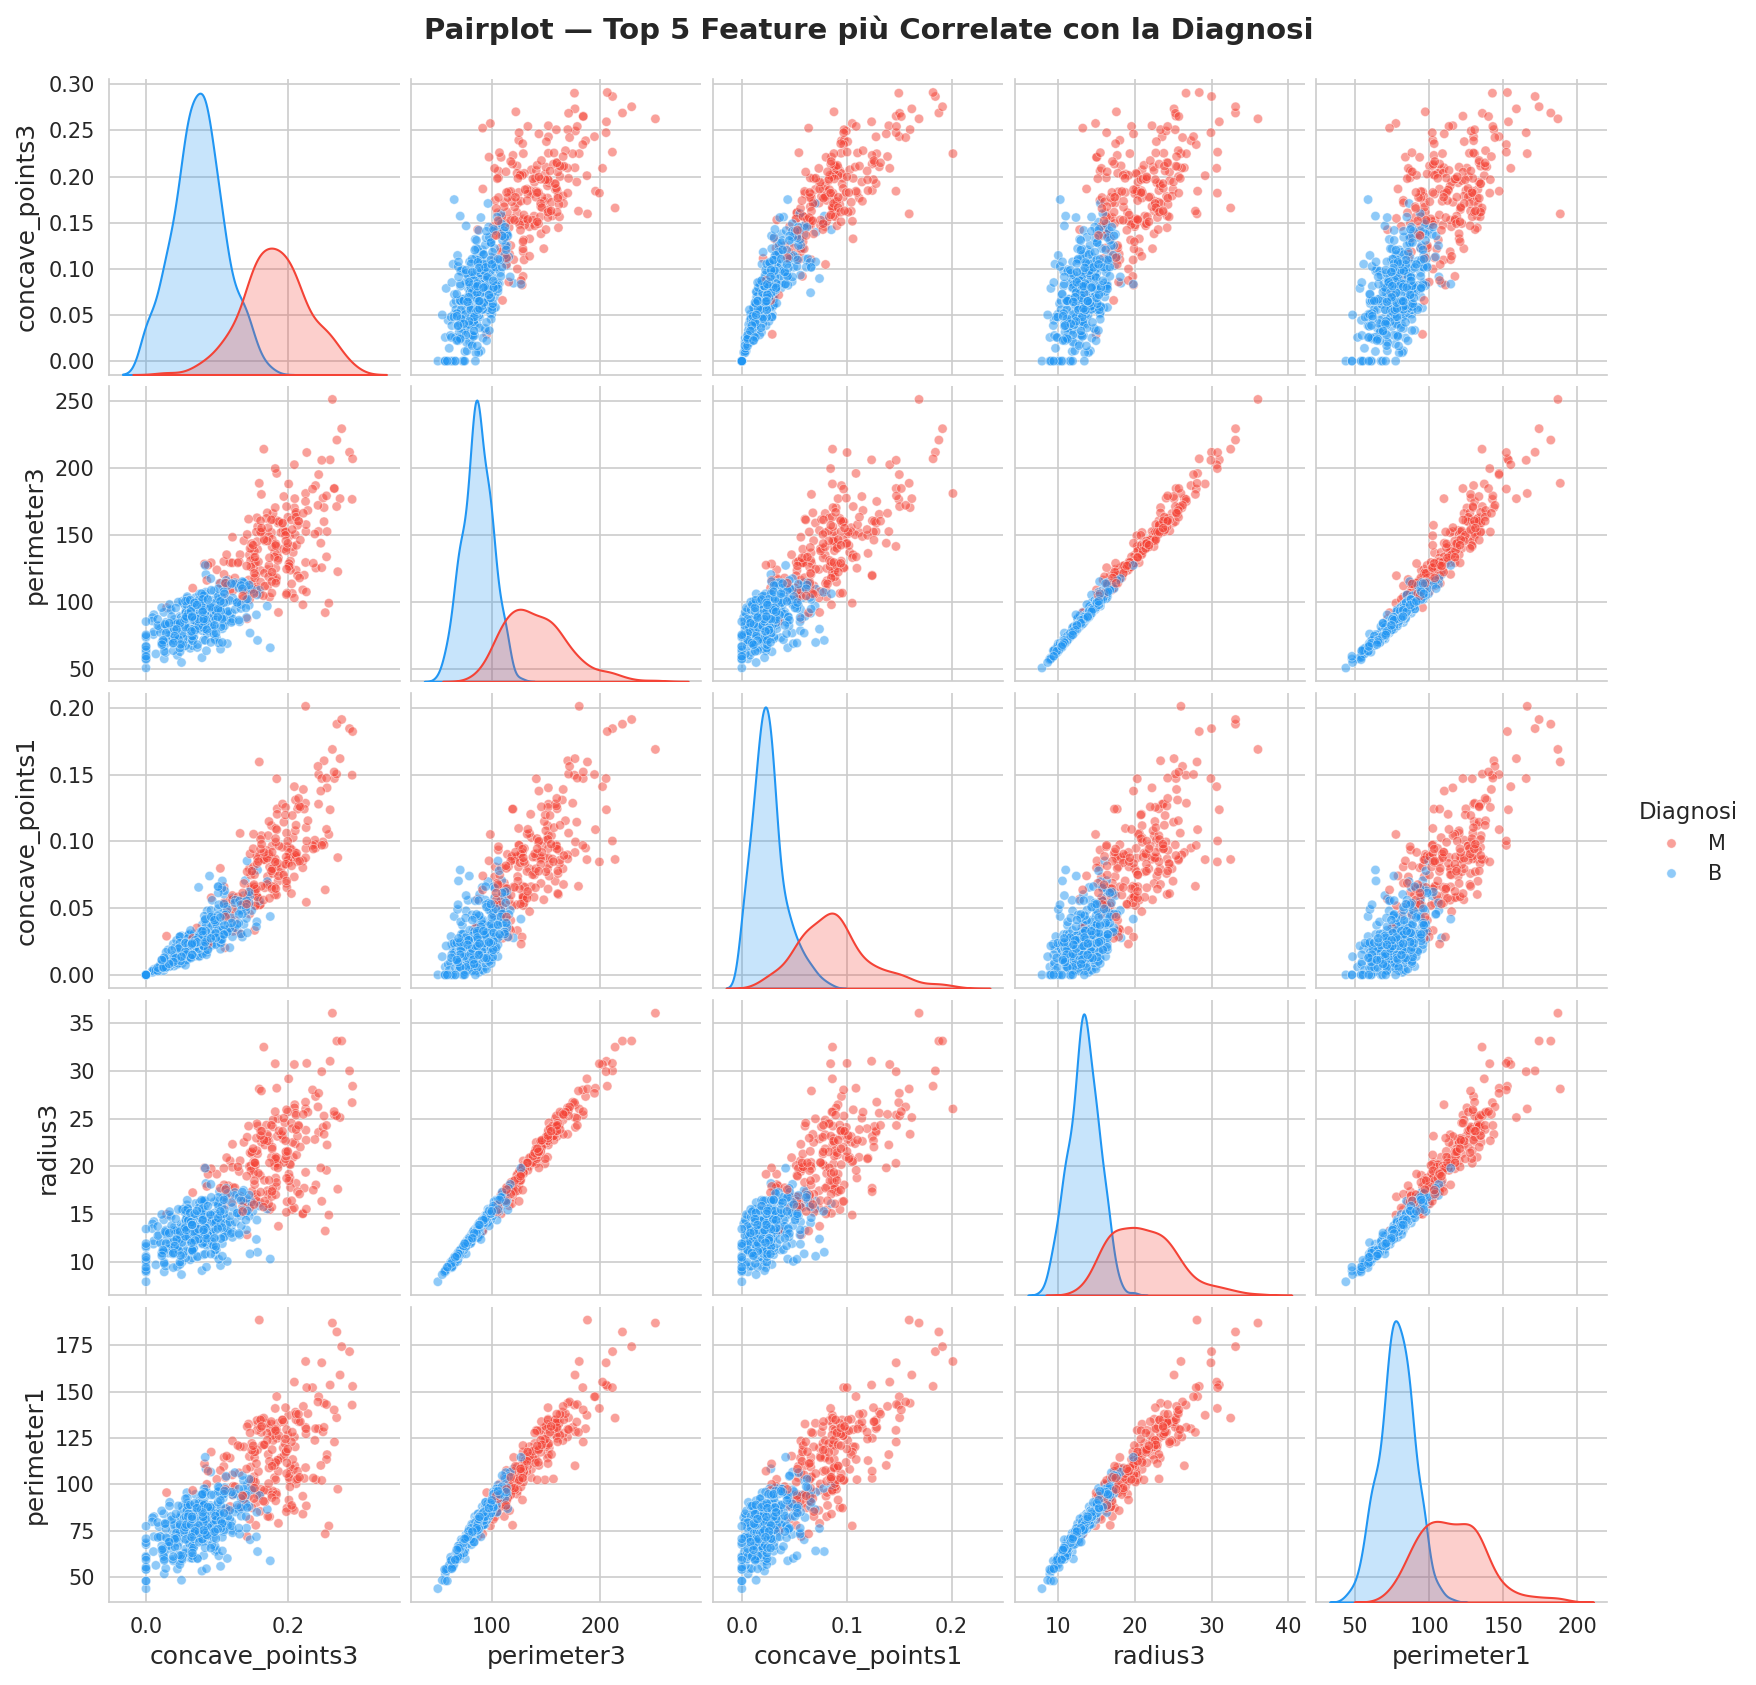

In [14]:
# ============================================================
# PAIRPLOT DELLE TOP 5 FEATURE PIÙ CORRELATE CON IL TARGET
# ============================================================

top5_features = corr_target.abs().sort_values(ascending=False).head(5).index.tolist()

print(f"Feature selezionate per il pairplot: {top5_features}")

plot_df = df[top5_features + ['Diagnosi']].copy()

g = sns.pairplot(plot_df, hue='Diagnosi',
                 palette={'B': '#2196F3', 'M': '#F44336'},
                 diag_kind='kde', plot_kws={'alpha': 0.5, 's': 20},
                 height=2.2)
g.figure.suptitle('Pairplot — Top 5 Feature più Correlate con la Diagnosi',
                  fontweight='bold', fontsize=14, y=1.02)
plt.savefig('pairplot_top5.png', dpi=200, bbox_inches='tight')
plt.show()

## 6. 🤖 Machine Learning Models

### 6.1 Preprocessing dei Dati

In [15]:
# ============================================================
# PREPROCESSING: SPLIT E STANDARDIZZAZIONE
# ============================================================

# Split stratificato train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

print("=" * 60)
print("SPLIT TRAIN/TEST")
print("=" * 60)
print(f"Training set:  {X_train.shape[0]} campioni ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Test set:      {X_test.shape[0]} campioni ({X_test.shape[0]/len(X)*100:.0f}%)")
print(f"\nDistribuzione classi nel training set:")
print(f"  Benigno: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"  Maligno: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
print(f"\nDistribuzione classi nel test set:")
print(f"  Benigno: {(y_test == 0).sum()} ({(y_test == 0).mean()*100:.1f}%)")
print(f"  Maligno: {(y_test == 1).sum()} ({(y_test == 1).mean()*100:.1f}%)")

# Standardizzazione (fit solo su training, transform su entrambi)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertiamo in DataFrame per comodità
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print(f"\n✅ Standardizzazione completata (StandardScaler)")
print(f"   Media training post-scaling: {X_train_scaled.mean().mean():.6f} (≈ 0)")
print(f"   Std training post-scaling:   {X_train_scaled.std().mean():.6f} (≈ 1)")

SPLIT TRAIN/TEST
Training set:  455 campioni (80%)
Test set:      114 campioni (20%)

Distribuzione classi nel training set:
  Benigno: 285 (62.6%)
  Maligno: 170 (37.4%)

Distribuzione classi nel test set:
  Benigno: 72 (63.2%)
  Maligno: 42 (36.8%)

✅ Standardizzazione completata (StandardScaler)
   Media training post-scaling: 0.000000 (≈ 0)
   Std training post-scaling:   1.001101 (≈ 1)


### 6.2 Definizione dei Modelli

Sono stati selezionati i seguenti modelli supervisionati, ciascuno con un rationale specifico:

1. **Logistic Regression**: Modello lineare di riferimento (baseline), interpretabile e ben consolidato in ambito clinico. Ottimo per problemi di classificazione binaria con feature continue.

2. **Support Vector Machine (SVM)**: Efficace in spazi ad alta dimensionalità, robusto rispetto all'overfitting quando il numero di feature è elevato rispetto ai campioni. Il kernel RBF consente di catturare relazioni non lineari.

3. **Random Forest**: Modello ensemble basato su alberi decisionali, robusto rispetto a outlier e feature non informative. Fornisce naturalmente una stima dell'importanza delle feature.

4. **Gradient Boosting**: Modello ensemble sequenziale che ottimizza iterativamente gli errori residui. Generalmente raggiunge performance elevate su dataset tabulari.

In [16]:
# ============================================================
# DEFINIZIONE DEI MODELLI CON PARAMETRI DI BASE
# ============================================================

modelli = {
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_STATE, max_iter=10000, solver='lbfgs'
    ),
    'SVM (RBF)': SVC(
        random_state=RANDOM_STATE, probability=True, kernel='rbf'
    ),
    'Random Forest': RandomForestClassifier(
        random_state=RANDOM_STATE, n_estimators=100
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=RANDOM_STATE, n_estimators=100
    )
}

print("Modelli definiti:")
for nome, modello in modelli.items():
    print(f"  ✅ {nome}: {modello.__class__.__name__}")

Modelli definiti:
  ✅ Logistic Regression: LogisticRegression
  ✅ SVM (RBF): SVC
  ✅ Random Forest: RandomForestClassifier
  ✅ Gradient Boosting: GradientBoostingClassifier


## 7. 🧪 Experimental Campaign

### 7.1 Cross-Validation con Modelli Base

In [17]:
# ============================================================
# CROSS-VALIDATION STRATIFICATA (10-FOLD)
# ============================================================

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# Metriche multiple tramite cross-validation
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = {}

print("=" * 60)
print("CROSS-VALIDATION STRATIFICATA (10-Fold) — MODELLI BASE")
print("=" * 60)

for nome, modello in modelli.items():
    print(f"\n🔄 Valutando: {nome}...")
    cv_results[nome] = {}

    for metric in scoring_metrics:
        scores = cross_val_score(modello, X_train_scaled, y_train,
                                cv=cv, scoring=metric, n_jobs=-1)
        cv_results[nome][metric] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }

    print(f"   Accuracy:  {cv_results[nome]['accuracy']['mean']:.4f} "
          f"(±{cv_results[nome]['accuracy']['std']:.4f})")
    print(f"   F1-Score:  {cv_results[nome]['f1']['mean']:.4f} "
          f"(±{cv_results[nome]['f1']['std']:.4f})")
    print(f"   ROC-AUC:   {cv_results[nome]['roc_auc']['mean']:.4f} "
          f"(±{cv_results[nome]['roc_auc']['std']:.4f})")

# Tabella riassuntiva
print("\n" + "=" * 60)
print("TABELLA RIASSUNTIVA — CROSS-VALIDATION (10-Fold)")
print("=" * 60)

cv_summary = []
for nome in modelli:
    row = {'Modello': nome}
    for metric in scoring_metrics:
        m = cv_results[nome][metric]['mean']
        s = cv_results[nome][metric]['std']
        row[metric.upper()] = f"{m:.4f} ± {s:.4f}"
        row[f"{metric}_mean"] = m
    cv_summary.append(row)

cv_summary_df = pd.DataFrame(cv_summary)
display_cols = ['Modello', 'ACCURACY', 'PRECISION', 'RECALL', 'F1', 'ROC_AUC']
display(cv_summary_df[display_cols])

CROSS-VALIDATION STRATIFICATA (10-Fold) — MODELLI BASE

🔄 Valutando: Logistic Regression...
   Accuracy:  0.9758 (±0.0229)
   F1-Score:  0.9672 (±0.0309)
   ROC-AUC:   0.9952 (±0.0084)

🔄 Valutando: SVM (RBF)...
   Accuracy:  0.9714 (±0.0242)
   F1-Score:  0.9601 (±0.0351)
   ROC-AUC:   0.9942 (±0.0095)

🔄 Valutando: Random Forest...
   Accuracy:  0.9626 (±0.0355)
   F1-Score:  0.9484 (±0.0491)
   ROC-AUC:   0.9901 (±0.0127)

🔄 Valutando: Gradient Boosting...
   Accuracy:  0.9671 (±0.0264)
   F1-Score:  0.9547 (±0.0375)
   ROC-AUC:   0.9914 (±0.0119)

TABELLA RIASSUNTIVA — CROSS-VALIDATION (10-Fold)


,Modello,ACCURACY,PRECISION,RECALL,F1,ROC_AUC
0,Logistic Regression,0.9758 ± 0.0229,0.9775 ± 0.0372,0.9588 ± 0.0459,0.9672 ± 0.0309,0.9952 ± 0.0084
1,SVM (RBF),0.9714 ± 0.0242,0.9784 ± 0.0355,0.9471 ± 0.0718,0.9601 ± 0.0351,0.9942 ± 0.0095
2,Random Forest,0.9626 ± 0.0355,0.9635 ± 0.0398,0.9353 ± 0.0668,0.9484 ± 0.0491,0.9901 ± 0.0127
3,Gradient Boosting,0.9671 ± 0.0264,0.9645 ± 0.0291,0.9471 ± 0.0614,0.9547 ± 0.0375,0.9914 ± 0.0119


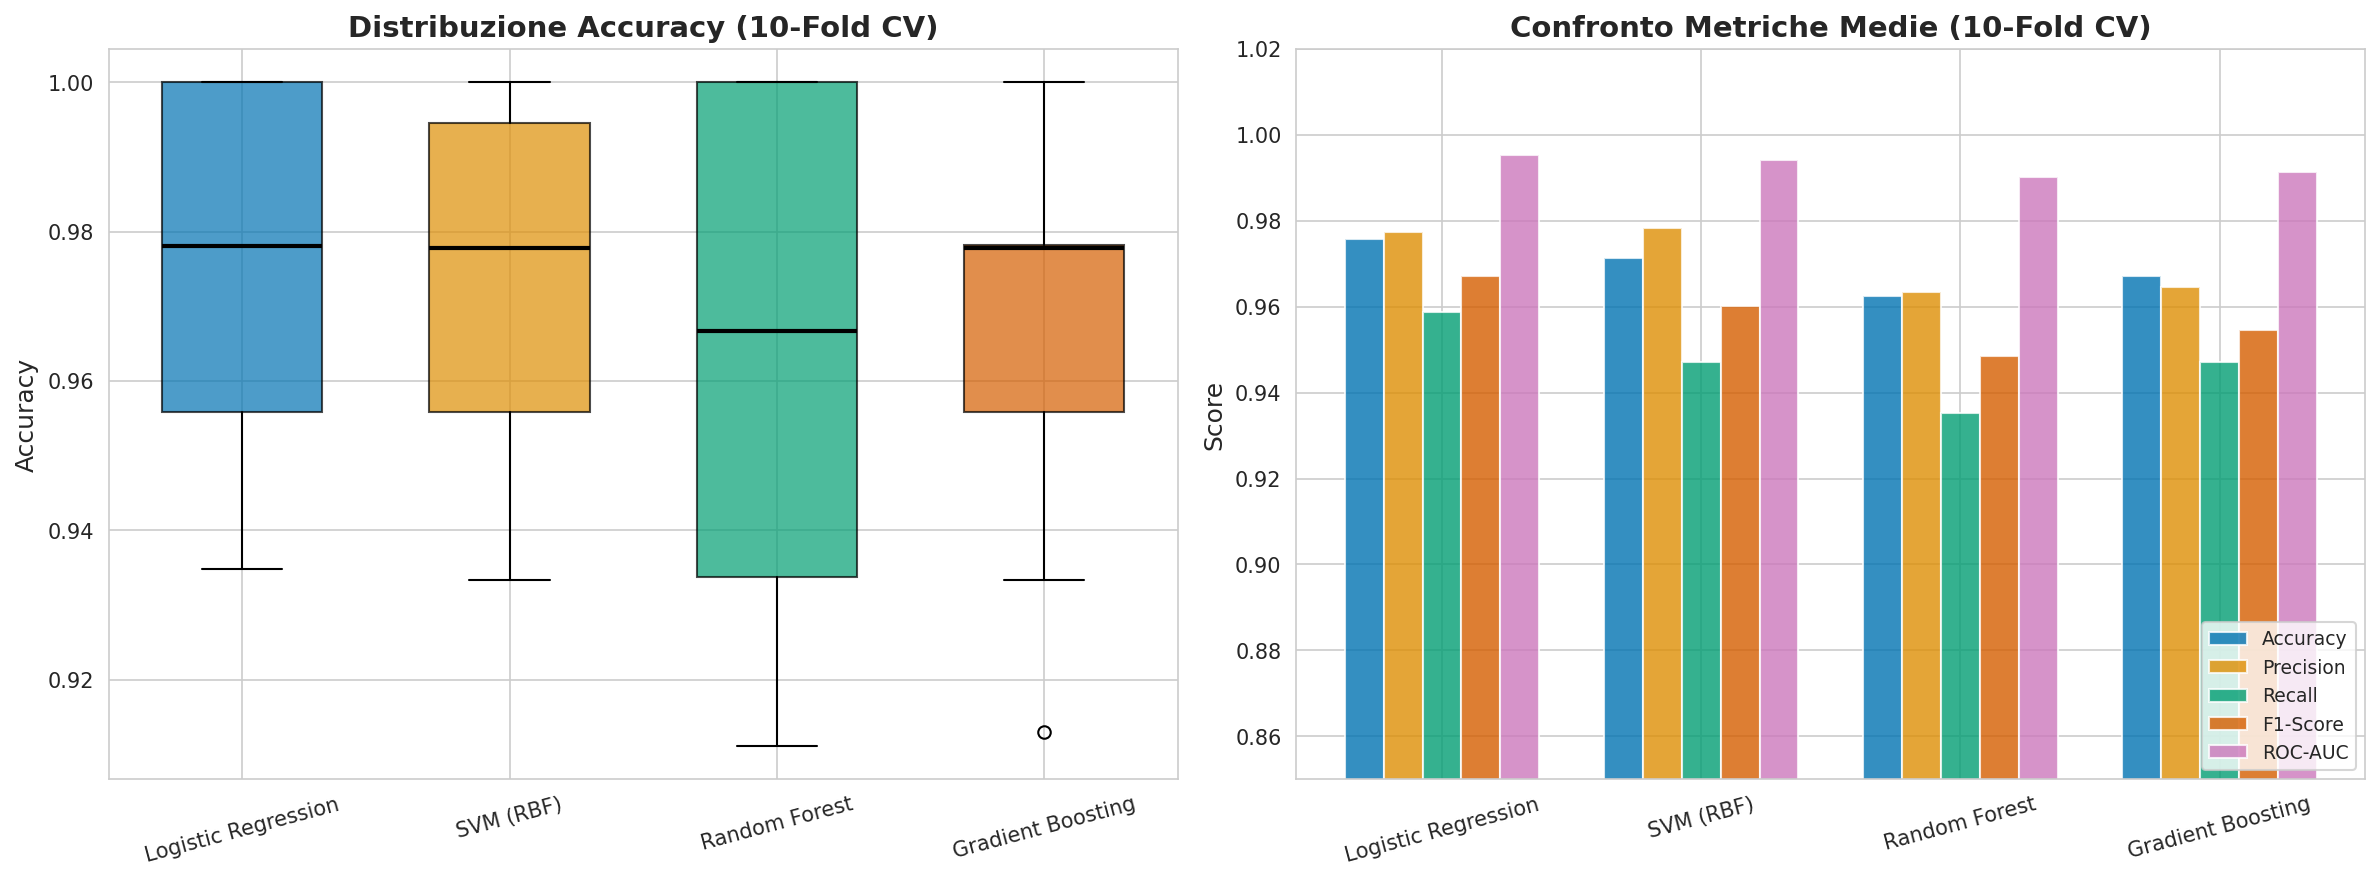

In [18]:
# ============================================================
# VISUALIZZAZIONE CROSS-VALIDATION
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot delle accuracy per modello
accuracy_data = [cv_results[nome]['accuracy']['scores'] for nome in modelli]
bp = axes[0].boxplot(accuracy_data, labels=list(modelli.keys()),
                     patch_artist=True, widths=0.6,
                     medianprops=dict(color='black', linewidth=2))
palette = sns.color_palette('colorblind', n_colors=4)
for patch, color in zip(bp['boxes'], palette):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0].set_title('Distribuzione Accuracy (10-Fold CV)', fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=15)

# Confronto metriche medie
x_pos = np.arange(len(modelli))
width = 0.15
metric_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for i, (metric, label) in enumerate(zip(metric_names, metric_labels)):
    values = [cv_results[nome][metric]['mean'] for nome in modelli]
    axes[1].bar(x_pos + i * width, values, width, label=label, alpha=0.8)

axes[1].set_xticks(x_pos + width * 2)
axes[1].set_xticklabels(list(modelli.keys()), rotation=15)
axes[1].set_ylabel('Score')
axes[1].set_title('Confronto Metriche Medie (10-Fold CV)', fontweight='bold')
axes[1].legend(loc='lower right', fontsize=9)
axes[1].set_ylim(0.85, 1.02)

plt.tight_layout()
plt.savefig('confronto_cv.png', dpi=300, bbox_inches='tight')
plt.show()

### 7.2 Hyperparameter Tuning

In [19]:
# ============================================================
# HYPERPARAMETER TUNING CON GRIDSEARCHCV
# ============================================================

# Griglie di iperparametri per ciascun modello
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs']
    },
    'SVM (RBF)': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.001],
        'kernel': ['rbf']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}

# Esecuzione GridSearchCV
best_models = {}
tuning_results = []

print("=" * 60)
print("HYPERPARAMETER TUNING (GridSearchCV, 5-Fold CV)")
print("=" * 60)

for nome, modello in modelli.items():
    print(f"\n🔧 Ottimizzando: {nome}...")
    n_combinazioni = 1
    for vals in param_grids[nome].values():
        n_combinazioni *= len(vals)
    print(f"   Combinazioni da testare: {n_combinazioni}")

    grid_search = GridSearchCV(
        estimator=modello,
        param_grid=param_grids[nome],
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        scoring='f1',  # Ottimizziamo su F1 (importante in ambito medico)
        n_jobs=-1,
        verbose=0,
        refit=True
    )

    grid_search.fit(X_train_scaled, y_train)
    best_models[nome] = grid_search.best_estimator_

    print(f"   Migliori parametri: {grid_search.best_params_}")
    print(f"   Miglior F1 (CV):    {grid_search.best_score_:.4f}")

    tuning_results.append({
        'Modello': nome,
        'Miglior F1 (CV)': f"{grid_search.best_score_:.4f}",
        'Migliori Parametri': str(grid_search.best_params_)
    })

# Tabella riassuntiva del tuning
print("\n" + "=" * 60)
print("RISULTATI HYPERPARAMETER TUNING")
print("=" * 60)
tuning_df = pd.DataFrame(tuning_results)
display(tuning_df)

HYPERPARAMETER TUNING (GridSearchCV, 5-Fold CV)

🔧 Ottimizzando: Logistic Regression...
   Combinazioni da testare: 5
   Migliori parametri: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
   Miglior F1 (CV):    0.9640

🔧 Ottimizzando: SVM (RBF)...
   Combinazioni da testare: 16
   Migliori parametri: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
   Miglior F1 (CV):    0.9698

🔧 Ottimizzando: Random Forest...
   Combinazioni da testare: 108
   Migliori parametri: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
   Miglior F1 (CV):    0.9553

🔧 Ottimizzando: Gradient Boosting...
   Combinazioni da testare: 54
   Migliori parametri: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
   Miglior F1 (CV):    0.9701

RISULTATI HYPERPARAMETER TUNING


,Modello,Miglior F1 (CV),Migliori Parametri
0,Logistic Regression,0.9640,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}"
1,SVM (RBF),0.9698,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}"
2,Random Forest,0.9553,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s..."
3,Gradient Boosting,0.9701,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti..."


### 7.3 Valutazione sul Test Set

In [20]:
# ============================================================
# VALUTAZIONE MODELLI OTTIMIZZATI SUL TEST SET
# ============================================================

test_results = []
predictions = {}

print("=" * 60)
print("VALUTAZIONE SUL TEST SET — MODELLI OTTIMIZZATI")
print("=" * 60)

for nome, modello in best_models.items():
    # Predizioni
    y_pred = modello.predict(X_test_scaled)
    y_prob = modello.predict_proba(X_test_scaled)[:, 1]

    predictions[nome] = {'y_pred': y_pred, 'y_prob': y_prob}

    # Calcolo metriche
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    test_results.append({
        'Modello': nome,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': auc
    })

    print(f"\n📊 {nome}")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   ROC-AUC:   {auc:.4f}")

# Tabella comparativa finale
print("\n" + "=" * 60)
print("TABELLA COMPARATIVA — PERFORMANCE SUL TEST SET")
print("=" * 60)
results_df = pd.DataFrame(test_results)
results_df_display = results_df.copy()
for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    results_df_display[col] = results_df_display[col].apply(lambda x: f"{x:.4f}")
display(results_df_display)

# Identificazione del modello migliore
best_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.loc[best_idx, 'Modello']
print(f"\n🏆 Modello migliore (per F1-Score): {best_model_name} "
      f"(F1 = {results_df.loc[best_idx, 'F1-Score']:.4f})")

VALUTAZIONE SUL TEST SET — MODELLI OTTIMIZZATI

📊 Logistic Regression
   Accuracy:  0.9649
   Precision: 0.9750
   Recall:    0.9286
   F1-Score:  0.9512
   ROC-AUC:   0.9960

📊 SVM (RBF)
   Accuracy:  0.9825
   Precision: 1.0000
   Recall:    0.9524
   F1-Score:  0.9756
   ROC-AUC:   0.9960

📊 Random Forest
   Accuracy:  0.9737
   Precision: 1.0000
   Recall:    0.9286
   F1-Score:  0.9630
   ROC-AUC:   0.9950

📊 Gradient Boosting
   Accuracy:  0.9649
   Precision: 1.0000
   Recall:    0.9048
   F1-Score:  0.9500
   ROC-AUC:   0.9977

TABELLA COMPARATIVA — PERFORMANCE SUL TEST SET


,Modello,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.9649,0.9750,0.9286,0.9512,0.9960
1,SVM (RBF),0.9825,1.0000,0.9524,0.9756,0.9960
2,Random Forest,0.9737,1.0000,0.9286,0.9630,0.9950
3,Gradient Boosting,0.9649,1.0000,0.9048,0.9500,0.9977



🏆 Modello migliore (per F1-Score): SVM (RBF) (F1 = 0.9756)


### 7.4 Confusion Matrices

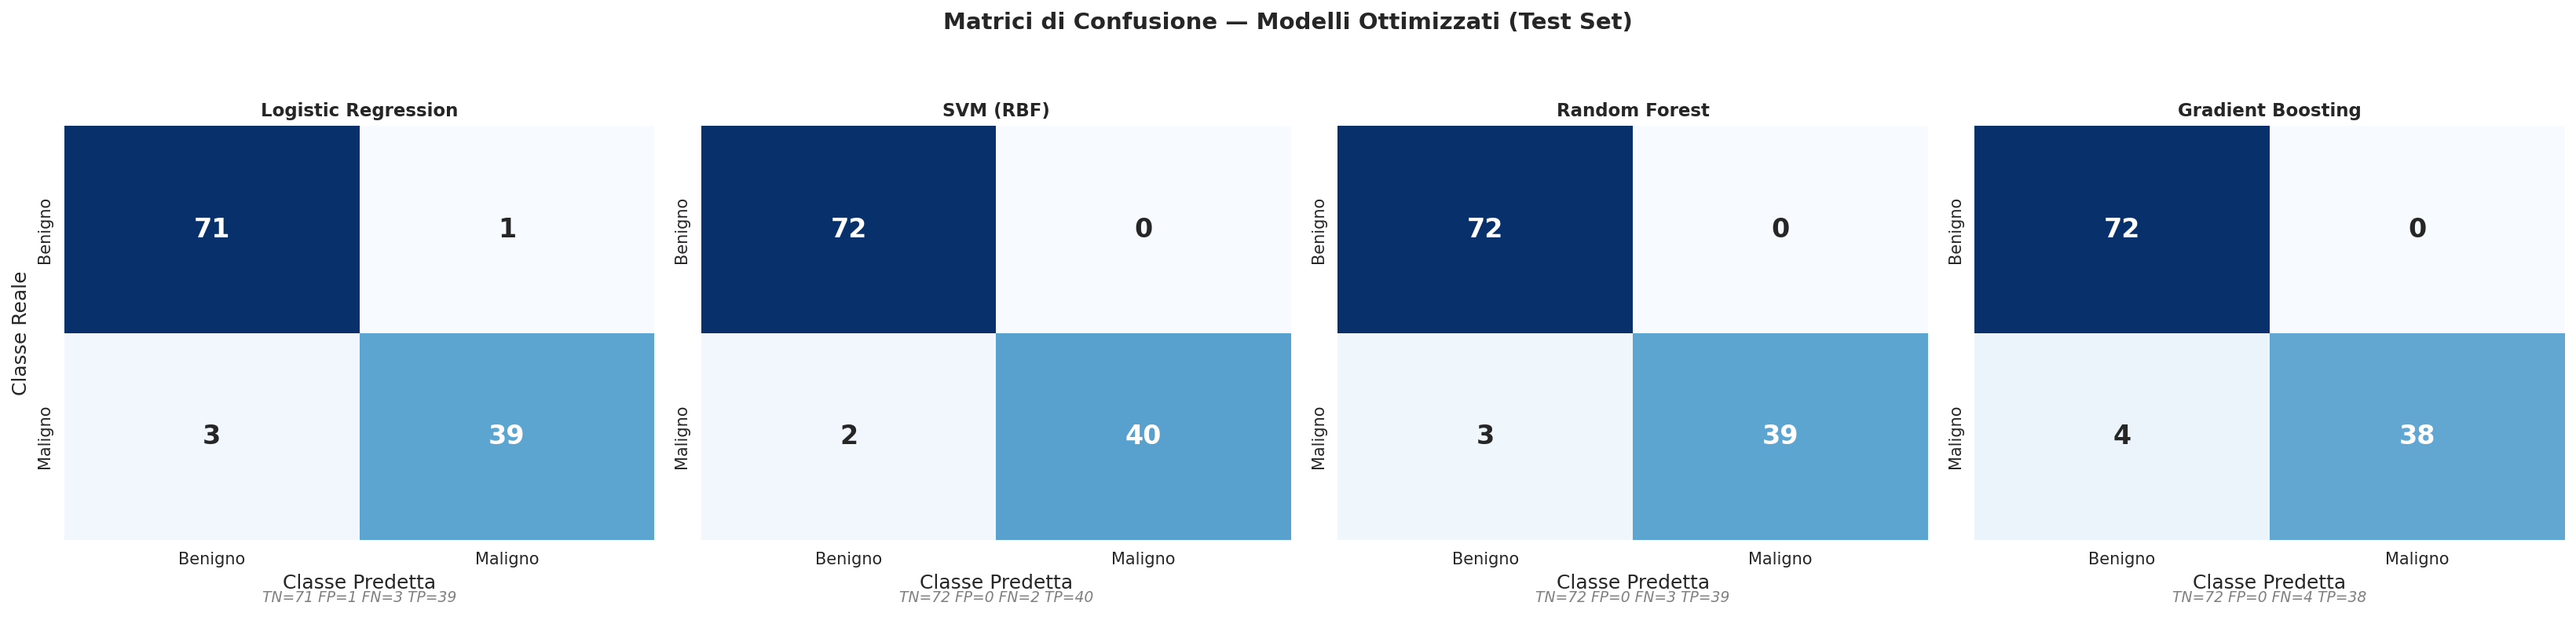


📌 Nota clinica importante:
   FN (Falsi Negativi) = tumori maligni classificati come benigni → ERRORE CRITICO
   FP (Falsi Positivi) = tumori benigni classificati come maligni → esami aggiuntivi
   In ambito oncologico, minimizzare i FN (massimizzare la Recall) è prioritario.


In [21]:
# ============================================================
# CONFUSION MATRICES PER TUTTI I MODELLI
# ============================================================

fig, axes = plt.subplots(1, 4, figsize=(22, 5))

for i, (nome, preds) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, preds['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Benigno', 'Maligno'],
                yticklabels=['Benigno', 'Maligno'],
                cbar=False, annot_kws={'size': 16, 'fontweight': 'bold'})
    axes[i].set_title(f'{nome}', fontweight='bold', fontsize=11)
    axes[i].set_ylabel('Classe Reale' if i == 0 else '')
    axes[i].set_xlabel('Classe Predetta')

    # Annotazioni per TN, FP, FN, TP
    tn, fp, fn, tp = cm.ravel()
    axes[i].text(0.5, -0.15, f'TN={tn} FP={fp} FN={fn} TP={tp}',
                transform=axes[i].transAxes, ha='center', fontsize=9,
                style='italic', color='gray')

fig.suptitle('Matrici di Confusione — Modelli Ottimizzati (Test Set)',
             fontweight='bold', fontsize=14, y=1.05)
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Nota clinica
print("\n📌 Nota clinica importante:")
print("   FN (Falsi Negativi) = tumori maligni classificati come benigni → ERRORE CRITICO")
print("   FP (Falsi Positivi) = tumori benigni classificati come maligni → esami aggiuntivi")
print("   In ambito oncologico, minimizzare i FN (massimizzare la Recall) è prioritario.")

In [22]:
# ============================================================
# CLASSIFICATION REPORT DETTAGLIATO PER IL MODELLO MIGLIORE
# ============================================================

print("=" * 60)
print(f"CLASSIFICATION REPORT — {best_model_name}")
print("=" * 60)
print(classification_report(
    y_test, predictions[best_model_name]['y_pred'],
    target_names=['Benigno (0)', 'Maligno (1)'],
    digits=4
))

CLASSIFICATION REPORT — SVM (RBF)
              precision    recall  f1-score   support

 Benigno (0)     0.9730    1.0000    0.9863        72
 Maligno (1)     1.0000    0.9524    0.9756        42

    accuracy                         0.9825       114
   macro avg     0.9865    0.9762    0.9810       114
weighted avg     0.9829    0.9825    0.9824       114



## 8. 📈 Results Analysis

### 8.1 Curve ROC

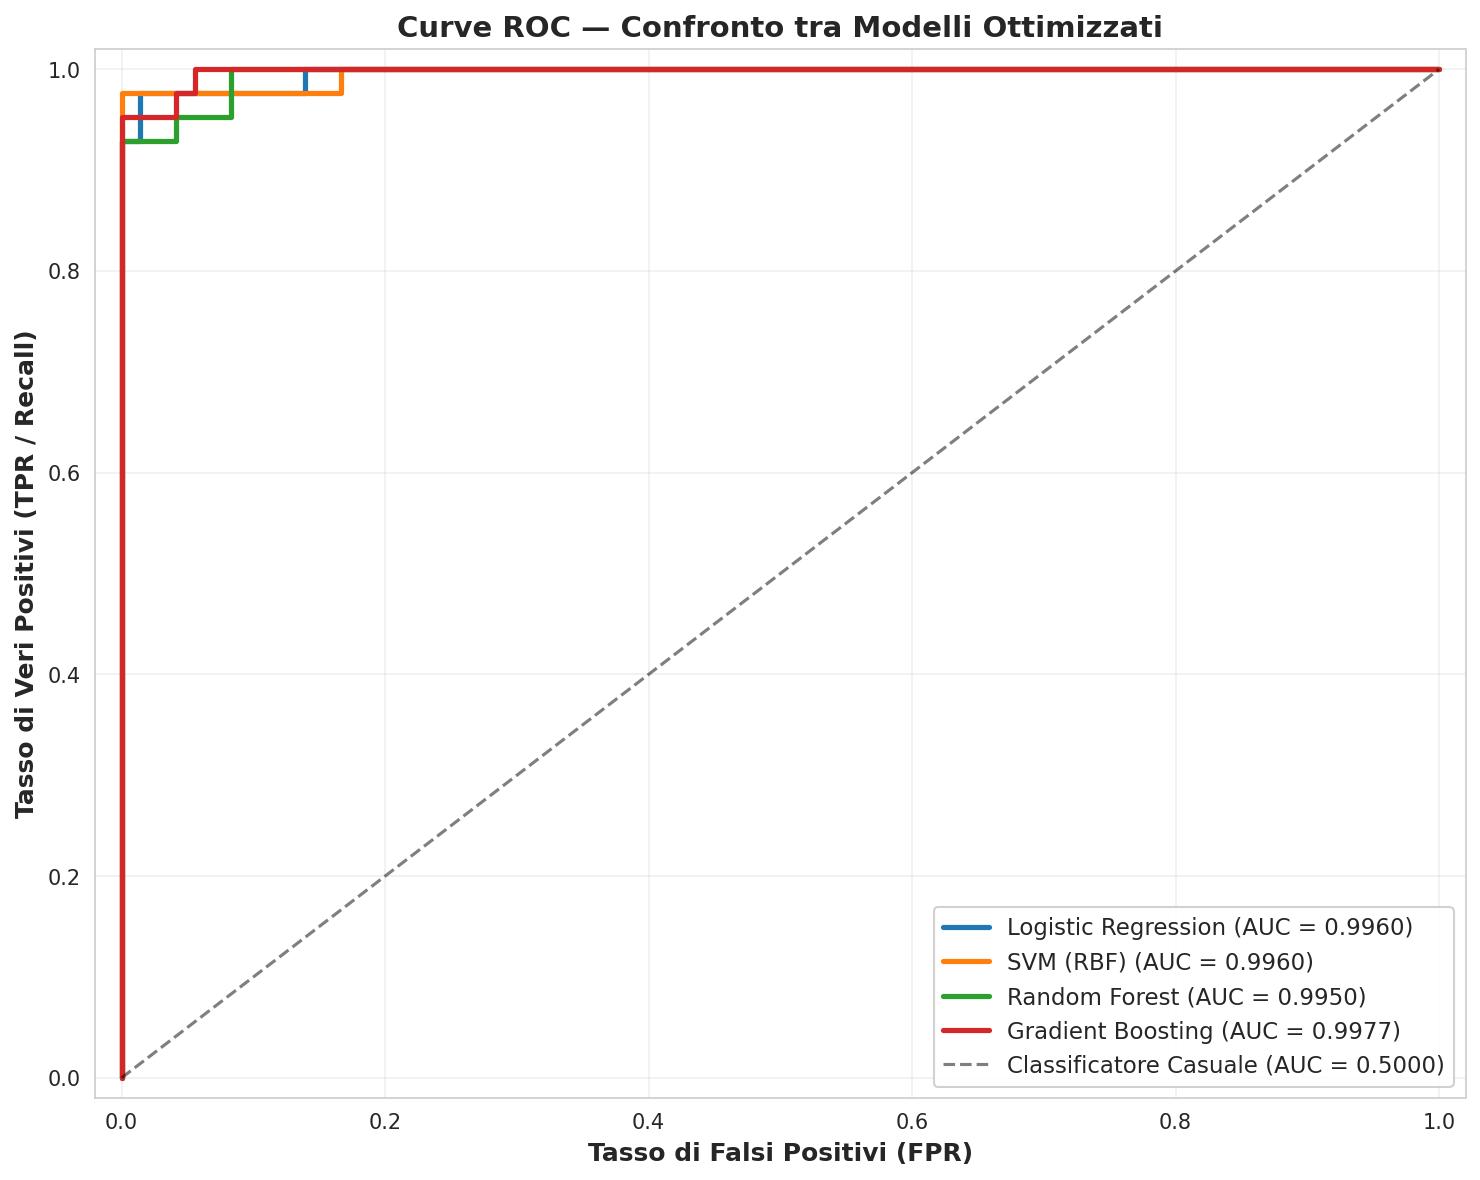

In [23]:
# ============================================================
# CURVE ROC PER TUTTI I MODELLI
# ============================================================

fig, ax = plt.subplots(figsize=(10, 8))

colors_roc = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (nome, preds) in enumerate(predictions.items()):
    fpr, tpr, _ = roc_curve(y_test, preds['y_prob'])
    auc_val = roc_auc_score(y_test, preds['y_prob'])
    ax.plot(fpr, tpr, color=colors_roc[i], linewidth=2.5,
            label=f'{nome} (AUC = {auc_val:.4f})')

# Linea di riferimento (classificatore casuale)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5,
        label='Classificatore Casuale (AUC = 0.5000)')

ax.set_xlabel('Tasso di Falsi Positivi (FPR)', fontweight='bold', fontsize=12)
ax.set_ylabel('Tasso di Veri Positivi (TPR / Recall)', fontweight='bold', fontsize=12)
ax.set_title('Curve ROC — Confronto tra Modelli Ottimizzati',
             fontweight='bold', fontsize=14)
ax.legend(loc='lower right', fontsize=11, framealpha=0.9)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### 8.2 Feature Importance

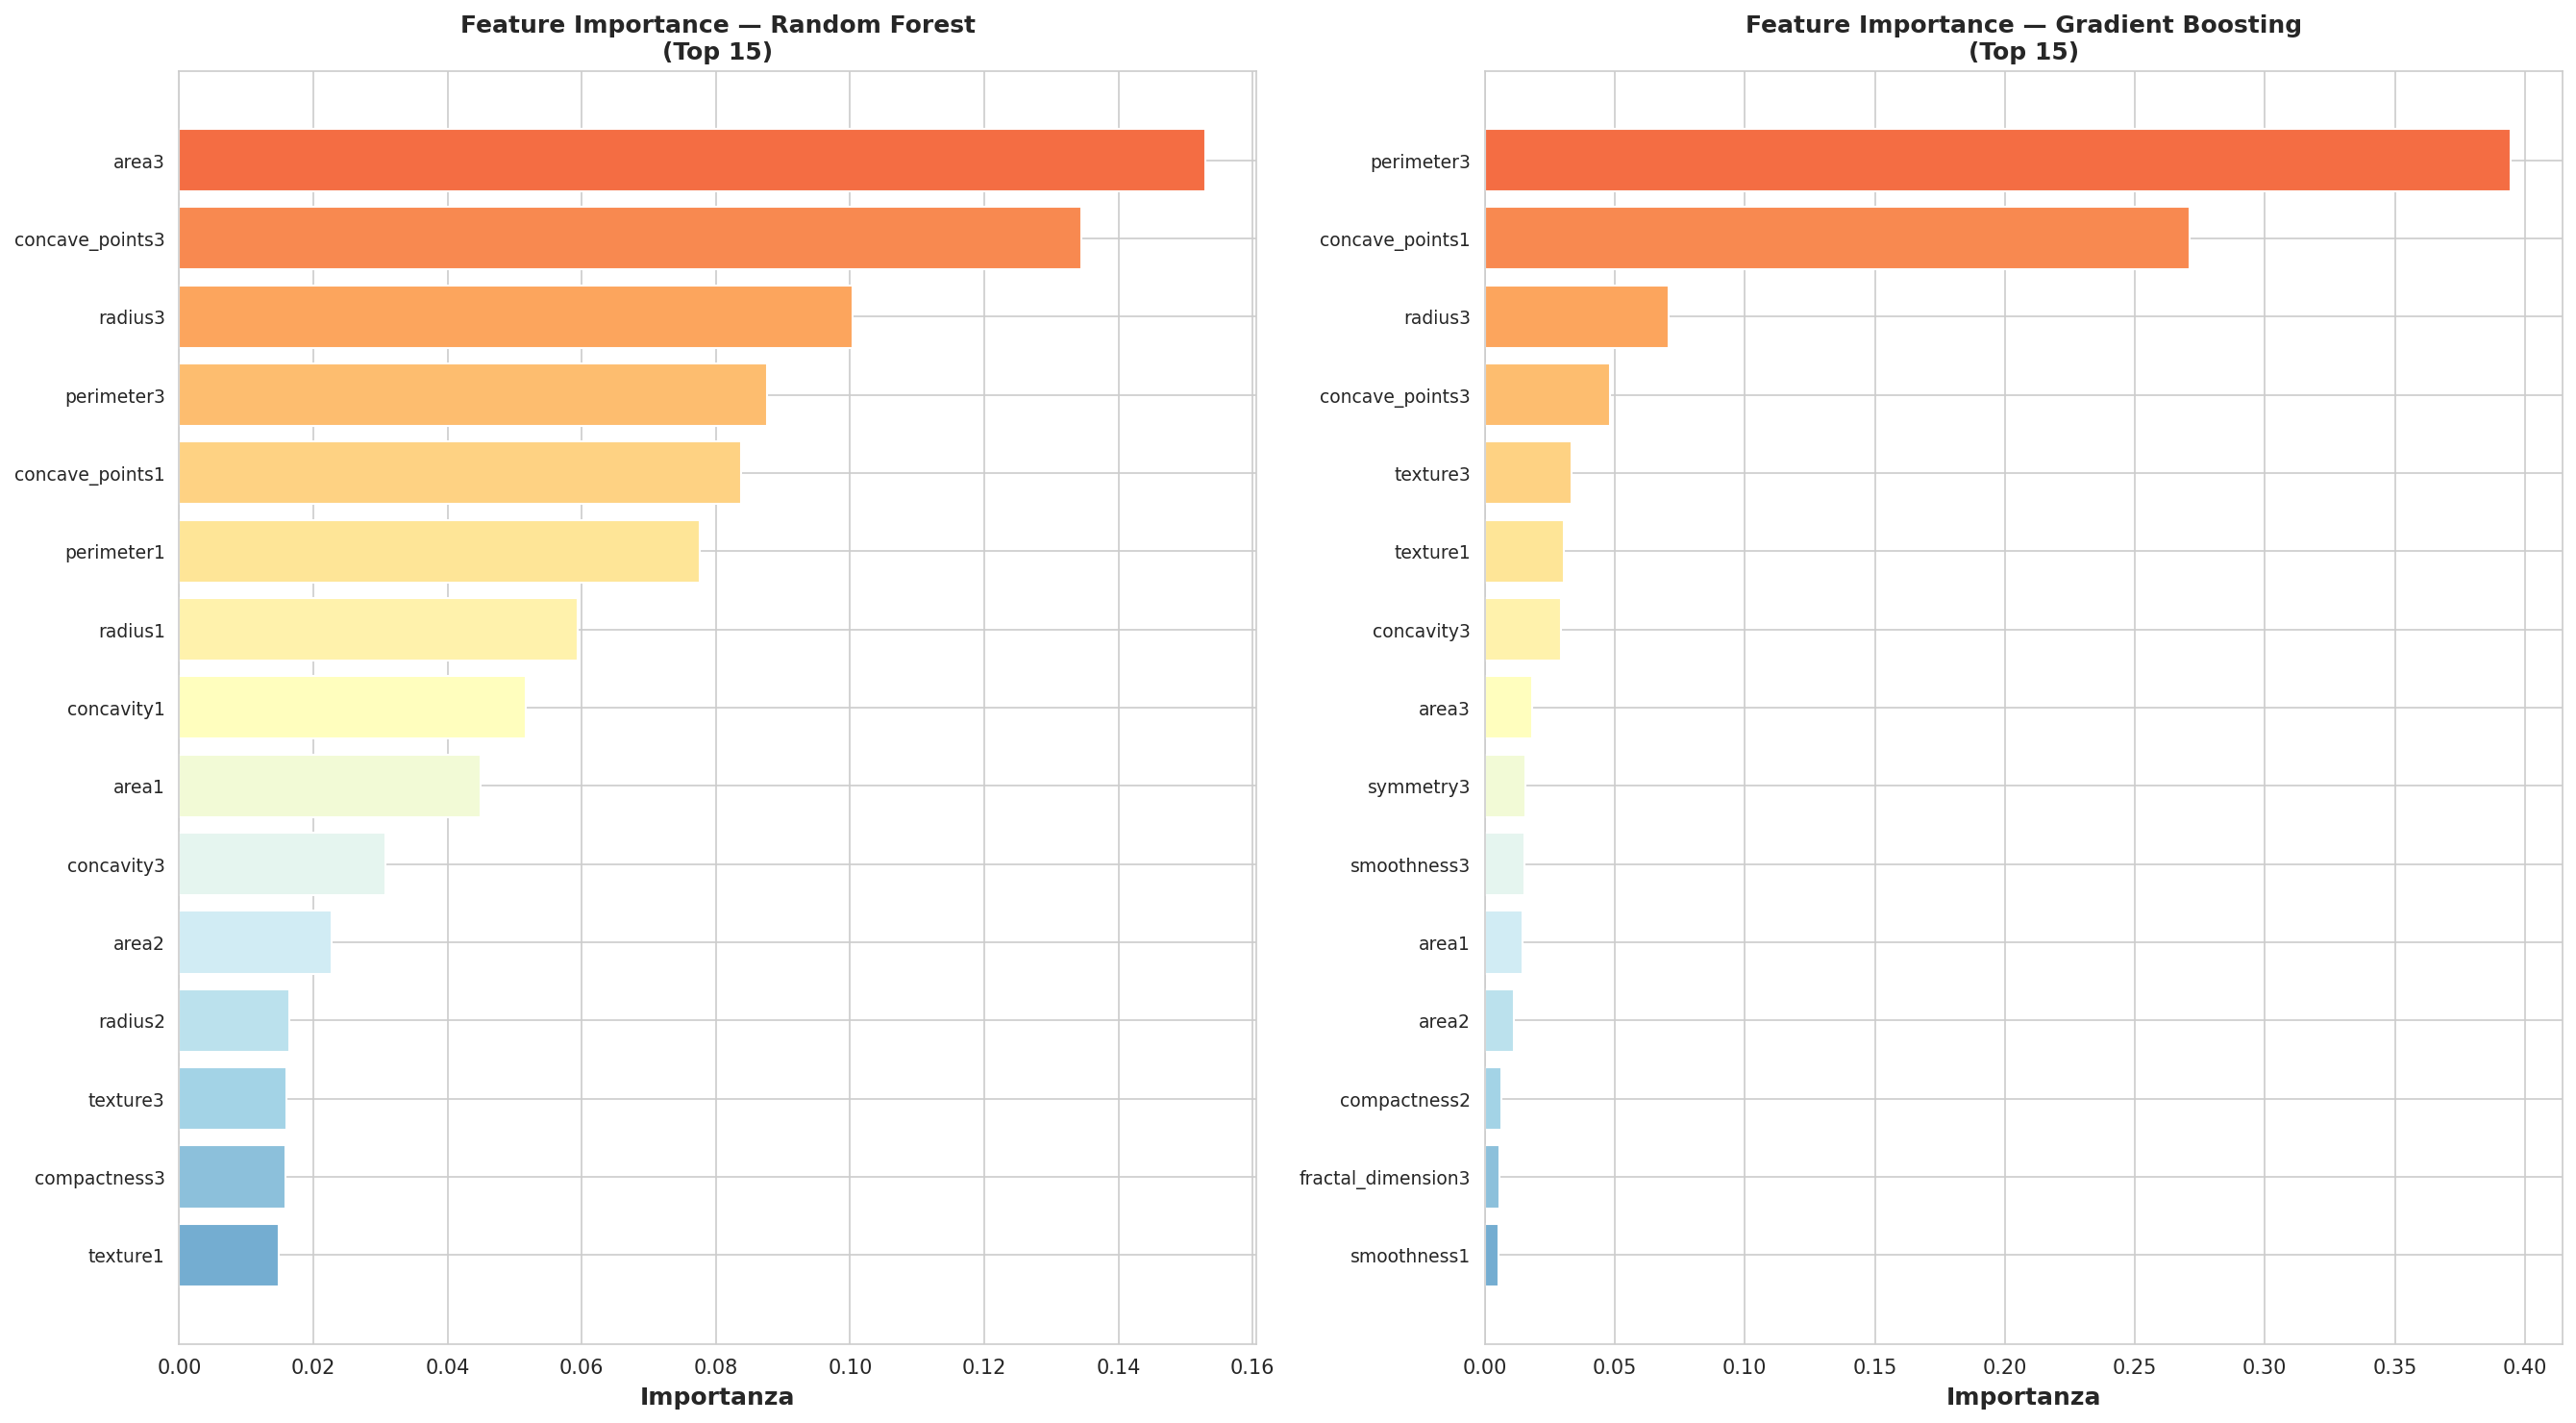


TOP 10 FEATURE PIÙ IMPORTANTI PER MODELLO


,Random Forest,Gradient Boosting
Rank,,
1,area3 (0.1529),perimeter3 (0.3946)
2,concave_points3 (0.1345),concave_points1 (0.2711)
3,radius3 (0.1004),radius3 (0.0708)
4,perimeter3 (0.0876),concave_points3 (0.0481)
5,concave_points1 (0.0837),texture3 (0.0332)
6,perimeter1 (0.0775),texture1 (0.0306)
7,radius1 (0.0594),concavity3 (0.0291)
8,concavity1 (0.0516),area3 (0.0181)
9,area1 (0.0449),symmetry3 (0.0155)


In [24]:
# ============================================================
# FEATURE IMPORTANCE — RANDOM FOREST & GRADIENT BOOSTING
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

for idx, nome in enumerate(['Random Forest', 'Gradient Boosting']):
    importances = best_models[nome].feature_importances_
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=True)

    # Prendiamo le top 15 feature
    top_feat = feat_imp.tail(15)

    colors_imp = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(top_feat)))
    axes[idx].barh(range(len(top_feat)), top_feat.values, color=colors_imp)
    axes[idx].set_yticks(range(len(top_feat)))
    axes[idx].set_yticklabels(top_feat.index, fontsize=9)
    axes[idx].set_xlabel('Importanza', fontweight='bold')
    axes[idx].set_title(f'Feature Importance — {nome}\n(Top 15)',
                       fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Tabella comparativa delle top 10 feature per ciascun modello
print("\n" + "=" * 60)
print("TOP 10 FEATURE PIÙ IMPORTANTI PER MODELLO")
print("=" * 60)

fi_comparison = pd.DataFrame()
for nome in ['Random Forest', 'Gradient Boosting']:
    imp = pd.Series(best_models[nome].feature_importances_, index=X.columns)
    top10 = imp.sort_values(ascending=False).head(10)
    fi_comparison[f'{nome}'] = [f"{f} ({v:.4f})" for f, v in top10.items()]

fi_comparison.index = range(1, 11)
fi_comparison.index.name = 'Rank'
display(fi_comparison)

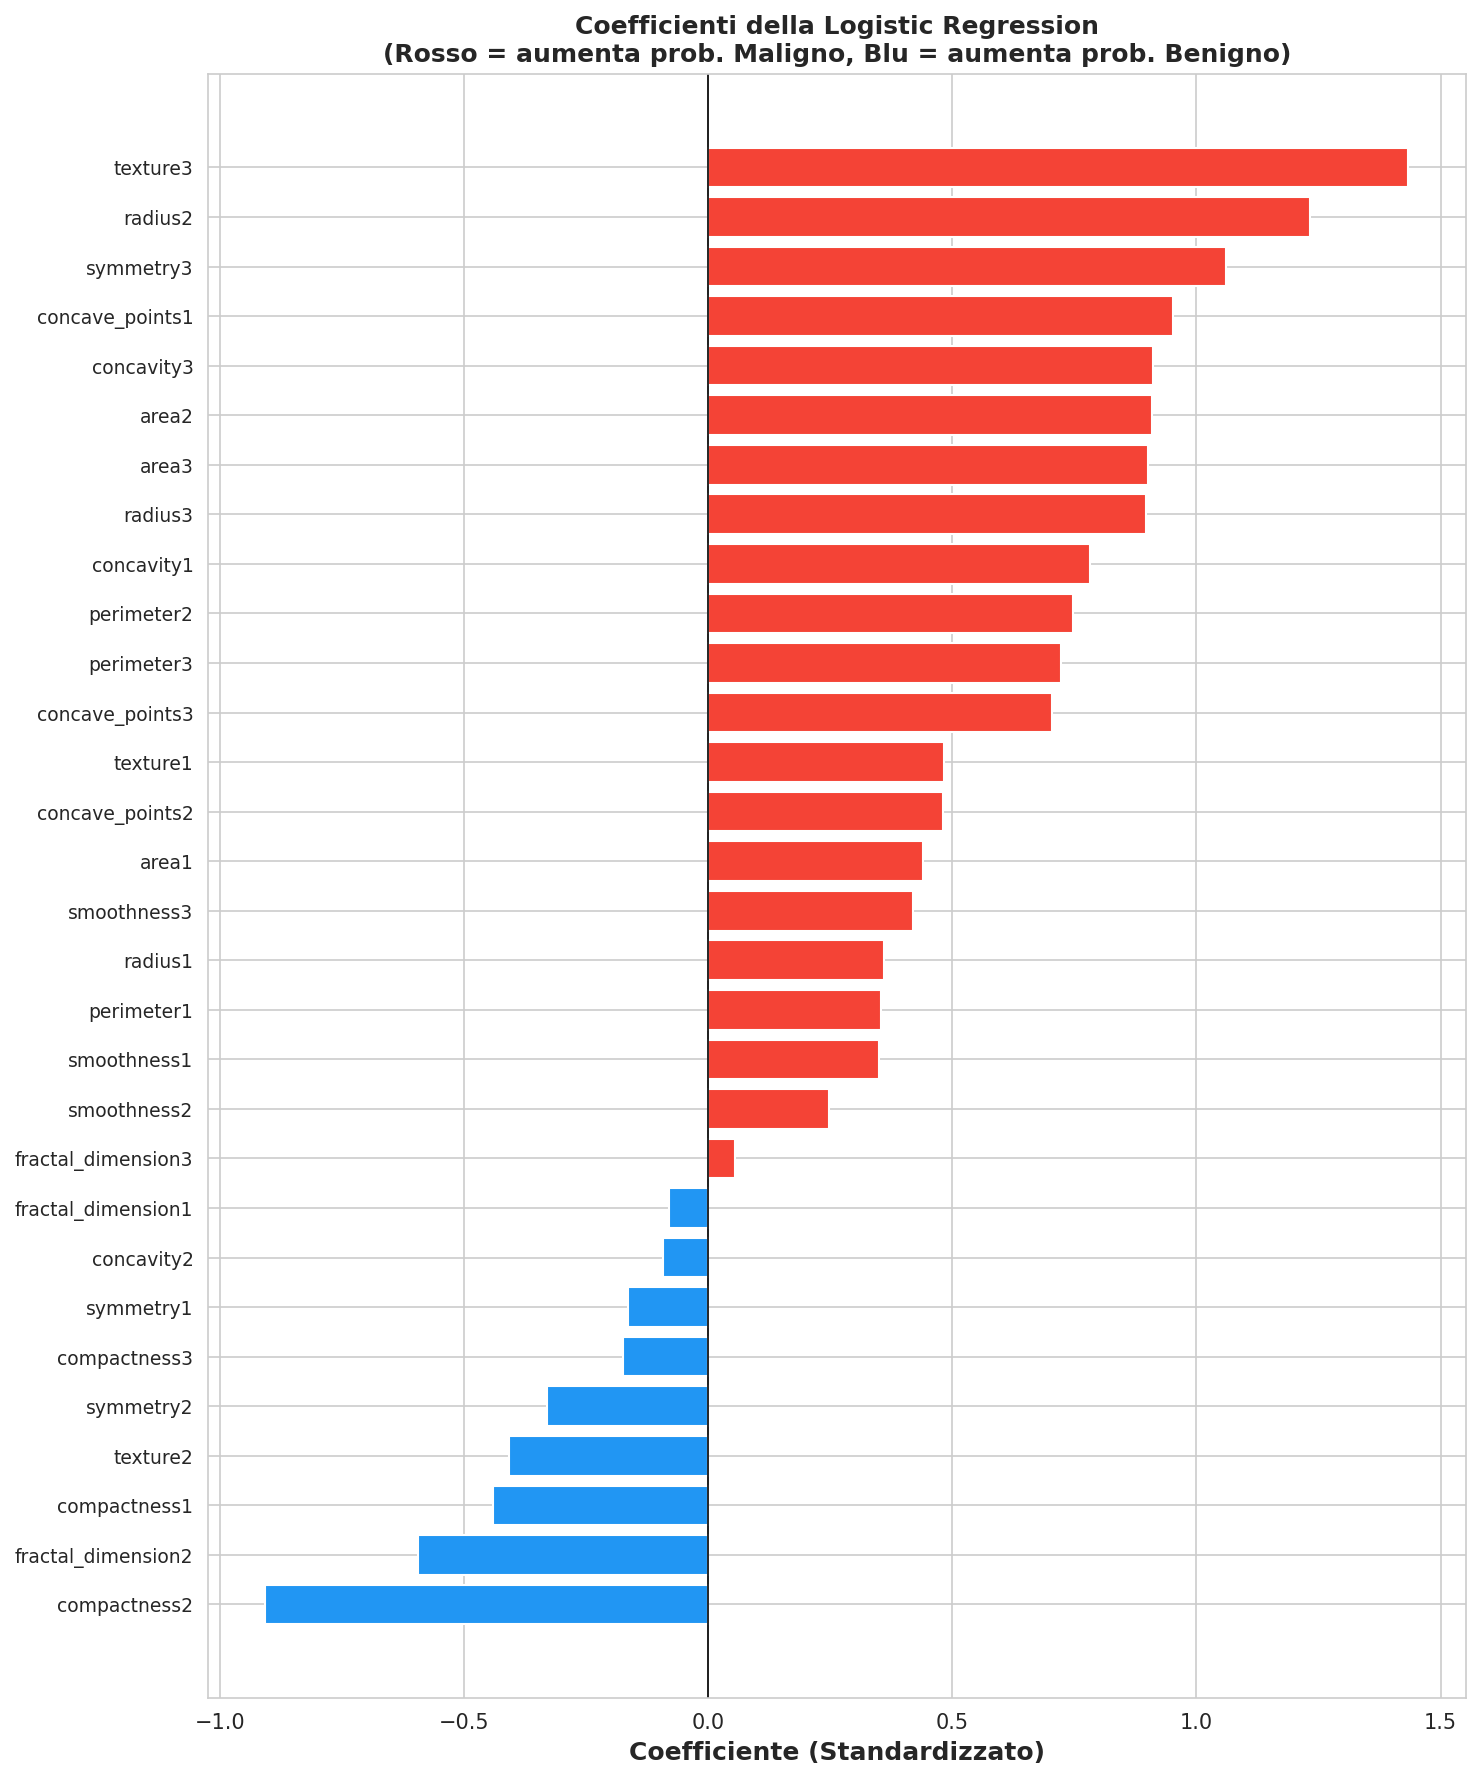

In [25]:
# ============================================================
# COEFFICIENTI LOGISTIC REGRESSION
# ============================================================

lr_coef = pd.Series(
    best_models['Logistic Regression'].coef_[0],
    index=X.columns
).sort_values()

fig, ax = plt.subplots(figsize=(10, 12))
colors_coef = ['#F44336' if v > 0 else '#2196F3' for v in lr_coef.values]
ax.barh(range(len(lr_coef)), lr_coef.values, color=colors_coef, edgecolor='white')
ax.set_yticks(range(len(lr_coef)))
ax.set_yticklabels(lr_coef.index, fontsize=9)
ax.set_xlabel('Coefficiente (Standardizzato)', fontweight='bold')
ax.set_title('Coefficienti della Logistic Regression\n'
             '(Rosso = aumenta prob. Maligno, Blu = aumenta prob. Benigno)',
             fontweight='bold', fontsize=12)
ax.axvline(x=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig('lr_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

### 8.3 Confronto Visivo Complessivo

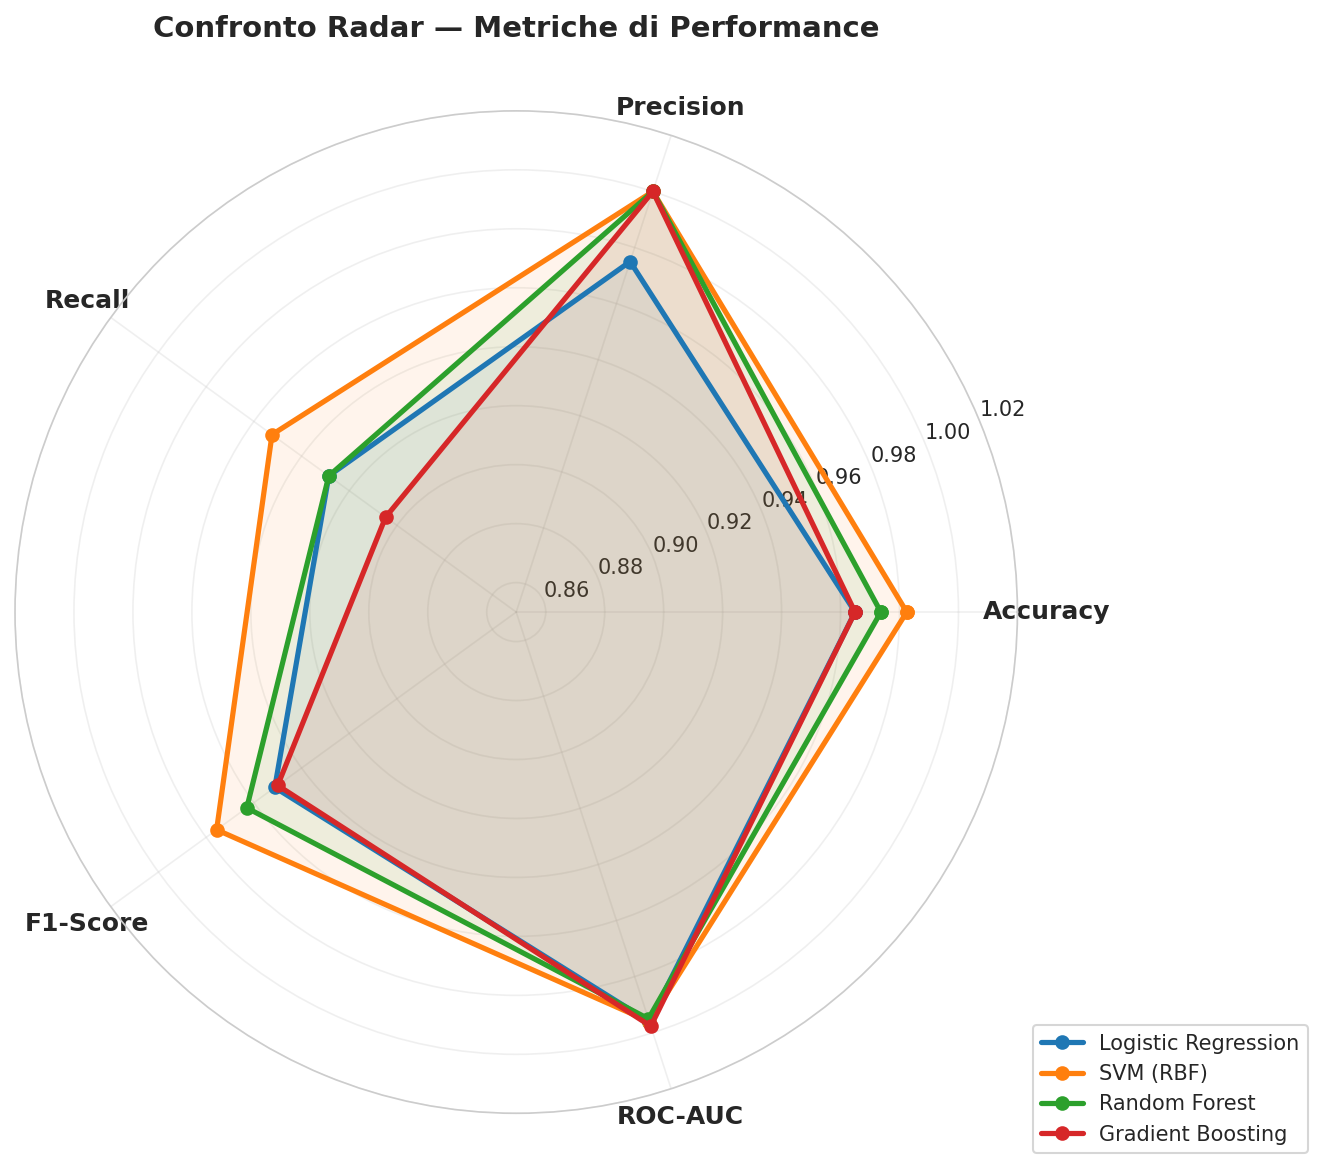

In [26]:
# ============================================================
# GRAFICO RADAR DELLE METRICHE PER MODELLO
# ============================================================

metrics_for_radar = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
n_metrics = len(metrics_for_radar)

# Angoli per il radar chart
angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
angles += angles[:1]  # Chiude il poligono

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))

for i, row in results_df.iterrows():
    values = [row[m] for m in metrics_for_radar]
    values += values[:1]  # Chiude il poligono
    ax.plot(angles, values, 'o-', linewidth=2.5, label=row['Modello'],
            color=colors_roc[i], markersize=6)
    ax.fill(angles, values, alpha=0.08, color=colors_roc[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_for_radar, fontsize=12, fontweight='bold')
ax.set_ylim(0.85, 1.02)
ax.set_title('Confronto Radar — Metriche di Performance\n',
             fontweight='bold', fontsize=14, pad=20)
ax.legend(loc='lower right', bbox_to_anchor=(1.3, -0.05), fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

### 8.4 Analisi Unsupervised — PCA & K-Means

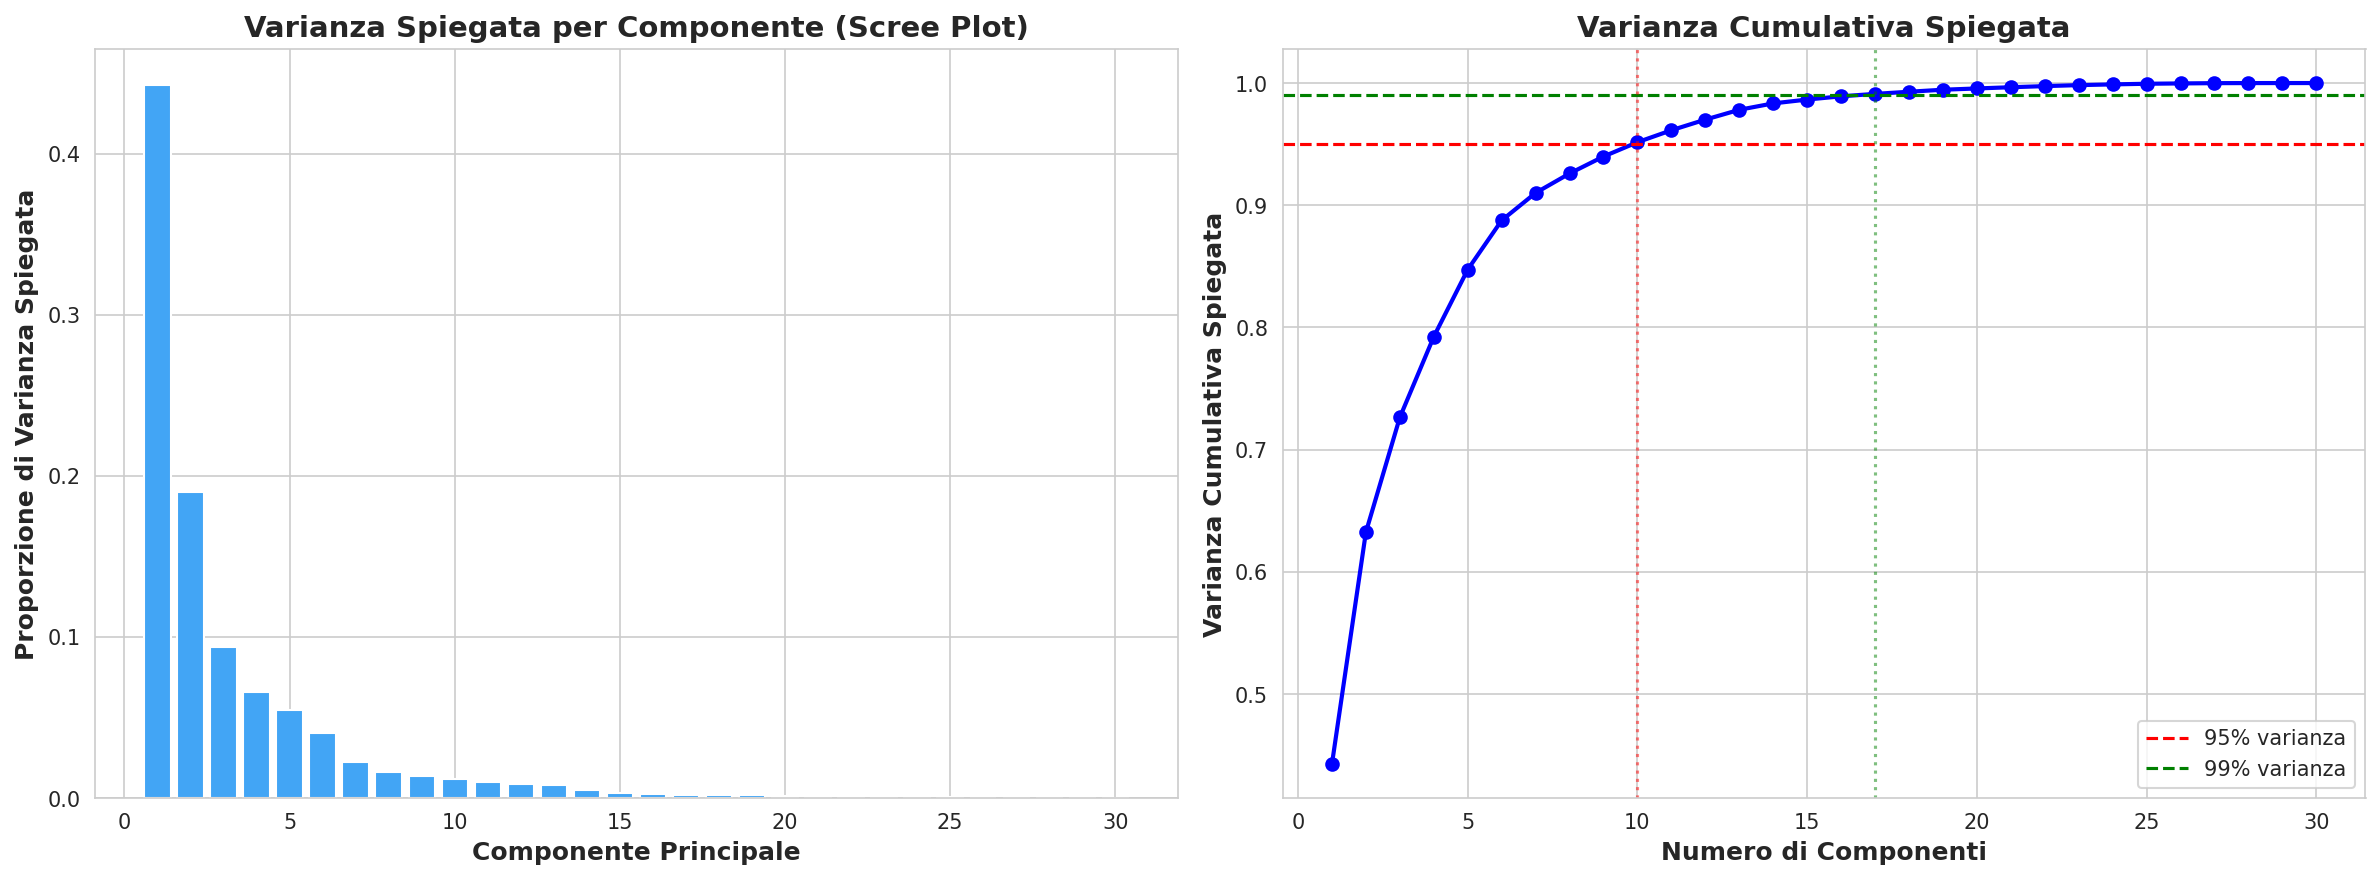

Componenti necessarie per il 95% della varianza: 10
Componenti necessarie per il 99% della varianza: 17
Varianza spiegata dalle prime 2 componenti: 63.24%


In [27]:
# ============================================================
# PCA — ANALISI DELLE COMPONENTI PRINCIPALI
# ============================================================

# PCA su tutto il dataset standardizzato
X_all_scaled = scaler.fit_transform(X)

# PCA completa per analisi della varianza spiegata
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_all_scaled)

# Varianza spiegata cumulativa
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Varianza spiegata per componente
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_, color='#42A5F5', edgecolor='white')
axes[0].set_xlabel('Componente Principale', fontweight='bold')
axes[0].set_ylabel('Proporzione di Varianza Spiegata', fontweight='bold')
axes[0].set_title('Varianza Spiegata per Componente (Scree Plot)', fontweight='bold')

# Varianza cumulativa
axes[1].plot(range(1, len(cumulative_var) + 1), cumulative_var, 'bo-', linewidth=2)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
axes[1].axhline(y=0.99, color='g', linestyle='--', label='99% varianza')
n_95 = np.argmax(cumulative_var >= 0.95) + 1
n_99 = np.argmax(cumulative_var >= 0.99) + 1
axes[1].axvline(x=n_95, color='r', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_99, color='g', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Numero di Componenti', fontweight='bold')
axes[1].set_ylabel('Varianza Cumulativa Spiegata', fontweight='bold')
axes[1].set_title('Varianza Cumulativa Spiegata', fontweight='bold')
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.savefig('pca_varianza.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Componenti necessarie per il 95% della varianza: {n_95}")
print(f"Componenti necessarie per il 99% della varianza: {n_99}")
print(f"Varianza spiegata dalle prime 2 componenti: {cumulative_var[1]*100:.2f}%")

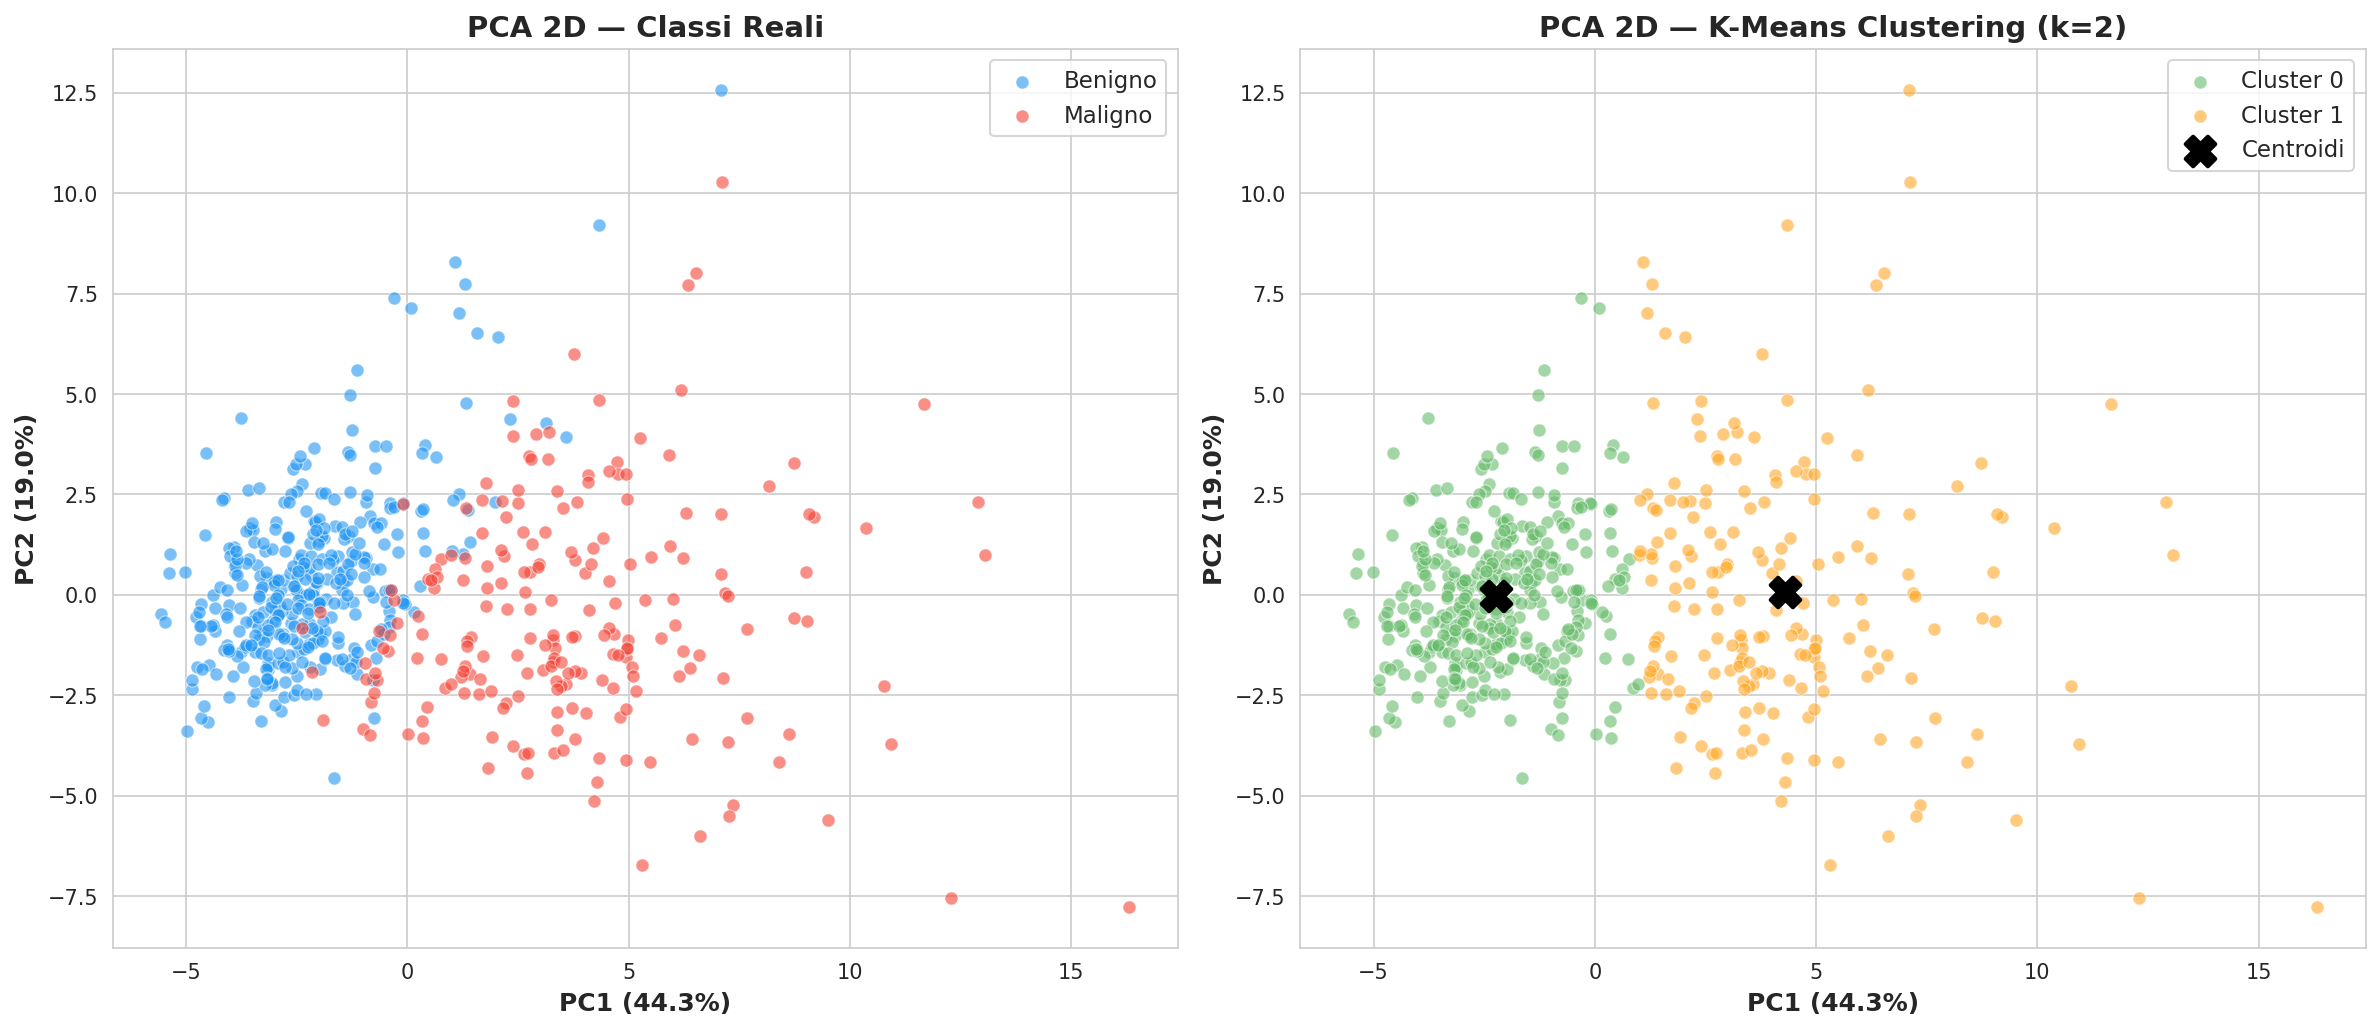


📊 Metriche del Clustering K-Means:
   Silhouette Score:       0.3434 (range [-1, 1], più alto = meglio)
   Adjusted Rand Index:    0.6536 (range [-1, 1], 1 = perfetto accordo con le classi reali)


In [28]:
# ============================================================
# PCA 2D — VISUALIZZAZIONE DELLE CLASSI NELLO SPAZIO RIDOTTO
# ============================================================

pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(X_all_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Classi reali
for classe, color, label in [(0, '#2196F3', 'Benigno'), (1, '#F44336', 'Maligno')]:
    mask = y_encoded == classe
    axes[0].scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1],
                   c=color, label=label, alpha=0.6, s=40, edgecolors='white', linewidth=0.5)

axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
axes[0].set_title('PCA 2D — Classi Reali', fontweight='bold')
axes[0].legend(fontsize=11)

# K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(X_all_scaled)

for cluster, color, label in [(0, '#66BB6A', 'Cluster 0'), (1, '#FFA726', 'Cluster 1')]:
    mask = clusters == cluster
    axes[1].scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1],
                   c=color, label=label, alpha=0.6, s=40, edgecolors='white', linewidth=0.5)

# Centroidi proiettati
centroids_pca = pca_2d.transform(kmeans.cluster_centers_)
axes[1].scatter(centroids_pca[:, 0], centroids_pca[:, 1],
               c='black', marker='X', s=200, linewidths=2, label='Centroidi')

axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
axes[1].set_title('PCA 2D — K-Means Clustering (k=2)', fontweight='bold')
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.savefig('pca_kmeans.png', dpi=300, bbox_inches='tight')
plt.show()

# Metriche clustering
sil_score = silhouette_score(X_all_scaled, clusters)
ari_score = adjusted_rand_score(y_encoded, clusters)

print(f"\n📊 Metriche del Clustering K-Means:")
print(f"   Silhouette Score:       {sil_score:.4f} (range [-1, 1], più alto = meglio)")
print(f"   Adjusted Rand Index:    {ari_score:.4f} (range [-1, 1], 1 = perfetto accordo con le classi reali)")

In [29]:
# ============================================================
# TABELLA DI CONTINGENZA K-MEANS VS CLASSI REALI
# ============================================================

contingency = pd.crosstab(
    pd.Series(y_encoded, name='Classe Reale').map({0: 'Benigno', 1: 'Maligno'}),
    pd.Series(clusters, name='Cluster K-Means').map({0: 'Cluster 0', 1: 'Cluster 1'}),
    margins=True
)

print("=" * 60)
print("TABELLA DI CONTINGENZA: K-Means vs Classi Reali")
print("=" * 60)
display(contingency)

print(f"\n📌 Il clustering K-Means, senza informazioni sulla diagnosi,")
print(f"   riesce a separare le classi con un ARI di {ari_score:.4f},")
print(f"   confermando la separabilità naturale dei dati.")

TABELLA DI CONTINGENZA: K-Means vs Classi Reali


Cluster K-Means,Cluster 0,Cluster 1,All
Classe Reale,,,
Benigno,339,18,357
Maligno,36,176,212
All,375,194,569



📌 Il clustering K-Means, senza informazioni sulla diagnosi,
   riesce a separare le classi con un ARI di 0.6536,
   confermando la separabilità naturale dei dati.


### 8.5 Tabella Riassuntiva Finale

In [30]:
# ============================================================
# TABELLA RIASSUNTIVA COMPLETA — ESPORTABILE
# ============================================================

# Combiniamo i risultati CV e test
final_summary = []

for i, nome in enumerate(modelli.keys()):
    row = {
        'Modello': nome,
        'CV Accuracy': f"{cv_results[nome]['accuracy']['mean']:.4f} ± {cv_results[nome]['accuracy']['std']:.4f}",
        'CV F1': f"{cv_results[nome]['f1']['mean']:.4f} ± {cv_results[nome]['f1']['std']:.4f}",
        'CV ROC-AUC': f"{cv_results[nome]['roc_auc']['mean']:.4f} ± {cv_results[nome]['roc_auc']['std']:.4f}",
        'Test Accuracy': f"{results_df.iloc[i]['Accuracy']:.4f}",
        'Test Precision': f"{results_df.iloc[i]['Precision']:.4f}",
        'Test Recall': f"{results_df.iloc[i]['Recall']:.4f}",
        'Test F1': f"{results_df.iloc[i]['F1-Score']:.4f}",
        'Test ROC-AUC': f"{results_df.iloc[i]['ROC-AUC']:.4f}"
    }
    final_summary.append(row)

final_df = pd.DataFrame(final_summary)

print("=" * 80)
print("TABELLA RIASSUNTIVA FINALE — TUTTI I RISULTATI")
print("=" * 80)
display(final_df)

# Salva la tabella in CSV per esportazione
final_df.to_csv('risultati_completi.csv', index=False)
print("\n✅ Risultati salvati in 'risultati_completi.csv'")

TABELLA RIASSUNTIVA FINALE — TUTTI I RISULTATI


,Modello,CV Accuracy,CV F1,CV ROC-AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC-AUC
0,Logistic Regression,0.9758 ± 0.0229,0.9672 ± 0.0309,0.9952 ± 0.0084,0.9649,0.9750,0.9286,0.9512,0.9960
1,SVM (RBF),0.9714 ± 0.0242,0.9601 ± 0.0351,0.9942 ± 0.0095,0.9825,1.0000,0.9524,0.9756,0.9960
2,Random Forest,0.9626 ± 0.0355,0.9484 ± 0.0491,0.9901 ± 0.0127,0.9737,1.0000,0.9286,0.9630,0.9950
3,Gradient Boosting,0.9671 ± 0.0264,0.9547 ± 0.0375,0.9914 ± 0.0119,0.9649,1.0000,0.9048,0.9500,0.9977



✅ Risultati salvati in 'risultati_completi.csv'


## 9. 🔍 Conclusions

### 9.1 Sintesi dei Risultati

In questo studio abbiamo applicato quattro algoritmi di Machine Learning supervisionato al problema della classificazione di tumori mammari utilizzando il dataset Breast Cancer Wisconsin (Diagnostic). I risultati principali sono:

**Analisi Esplorativa:**
- Il dataset contiene 569 campioni con 30 feature derivate dall'analisi citologica, senza valori mancanti
- Le classi sono moderatamente bilanciate (circa 63% benigni, 37% maligni)
- Esistono forti correlazioni tra feature della stessa famiglia (radius, perimeter, area)
- Le feature legate a dimensione e concavità mostrano il maggior potere discriminante

**Modelli Supervisionati:**
- Tutti e quattro i modelli raggiungono performance eccellenti (accuracy > 95% sul test set)
- L'analisi delle confusion matrices evidenzia un numero molto ridotto di falsi negativi, aspetto fondamentale in ambito clinico
- L'hyperparameter tuning ha permesso di migliorare le performance rispetto ai modelli base

**Analisi Non Supervisionata:**
- La PCA mostra che le prime 2 componenti spiegano oltre il 60% della varianza
- Il clustering K-Means, senza informazioni sulla diagnosi, riesce a identificare raggruppamenti coerenti con le classi reali
- Questo conferma l'ipotesi iniziale di separabilità naturale delle classi

### 9.2 Risposta agli Obiettivi

| Obiettivo | Esito |
|-----------|-------|
| Esplorare le caratteristiche morfologiche | ✅ EDA completa con identificazione delle feature chiave |
| Costruire modelli predittivi | ✅ 4 modelli implementati e ottimizzati |
| Confrontare le performance | ✅ Confronto sistematico con metriche multiple |
| Identificare feature discriminanti | ✅ Feature importance e analisi dei coefficienti |
| Valutare l'affidabilità clinica | ✅ Alta recall sulla classe maligna |

### 9.3 Limitazioni dello Studio

1. **Dimensione del dataset:** 569 campioni rappresentano un dataset relativamente piccolo; la generalizzabilità dei risultati richiede validazione su campioni più ampi
2. **Provenienza monocentrica:** I dati provengono da un singolo centro clinico, limitando la diversità del campione
3. **Assenza di variabili cliniche:** Non sono disponibili dati demografici, anamnestici o di follow-up
4. **Potenziale data leakage:** Le 30 feature sono derivate dalle stesse 10 misure base, creando ridondanza informativa
5. **Validazione esterna assente:** I modelli non sono stati validati su dataset indipendenti

### 9.4 Possibili Sviluppi Futuri

- **Feature selection avanzata:** Implementare metodi di selezione delle feature (LASSO, RFE) per ridurre la ridondanza e migliorare l'interpretabilità
- **Deep Learning:** Esplorare reti neurali, in particolare applicando CNN direttamente alle immagini citologiche originali
- **Ensemble avanzati:** Testare tecniche di stacking e blending dei modelli migliori
- **Validazione multicentrica:** Applicare i modelli a dataset provenienti da altri centri clinici
- **Explainability (XAI):** Utilizzare tecniche come SHAP o LIME per fornire spiegazioni interpretabili delle predizioni individuali
- **Analisi costi-benefici:** Implementare una matrice dei costi asimmetrica che tenga conto del diverso impatto clinico di falsi positivi e falsi negativi

In [31]:
# ============================================================
# RIEPILOGO GRAFICI SALVATI
# ============================================================

print("=" * 60)
print("GRAFICI SALVATI (alta risoluzione, 300 DPI)")
print("=" * 60)

grafici = [
    ('distribuzione_classi.png', 'Distribuzione delle classi diagnostiche'),
    ('distribuzioni_feature_mean.png', 'Istogrammi delle feature mean per classe'),
    ('boxplot_feature_mean.png', 'Boxplot delle feature mean per classe'),
    ('matrice_correlazione.png', 'Matrice di correlazione completa'),
    ('correlazione_target.png', 'Correlazione delle feature con il target'),
    ('outlier_analysis.png', 'Analisi degli outlier'),
    ('pairplot_top5.png', 'Pairplot delle top 5 feature'),
    ('confronto_cv.png', 'Confronto cross-validation'),
    ('confusion_matrices.png', 'Matrici di confusione'),
    ('roc_curves.png', 'Curve ROC'),
    ('feature_importance.png', 'Feature importance (RF e GB)'),
    ('lr_coefficients.png', 'Coefficienti Logistic Regression'),
    ('radar_chart.png', 'Grafico radar delle metriche'),
    ('pca_varianza.png', 'PCA — Varianza spiegata'),
    ('pca_kmeans.png', 'PCA 2D e K-Means clustering'),
]

for filename, desc in grafici:
    print(f"  📊 {filename:<35s} — {desc}")

print(f"\n📄 Tabella CSV: risultati_completi.csv")
print(f"\n✅ Progetto completato con successo!")

GRAFICI SALVATI (alta risoluzione, 300 DPI)
  📊 distribuzione_classi.png            — Distribuzione delle classi diagnostiche
  📊 distribuzioni_feature_mean.png      — Istogrammi delle feature mean per classe
  📊 boxplot_feature_mean.png            — Boxplot delle feature mean per classe
  📊 matrice_correlazione.png            — Matrice di correlazione completa
  📊 correlazione_target.png             — Correlazione delle feature con il target
  📊 outlier_analysis.png                — Analisi degli outlier
  📊 pairplot_top5.png                   — Pairplot delle top 5 feature
  📊 confronto_cv.png                    — Confronto cross-validation
  📊 confusion_matrices.png              — Matrici di confusione
  📊 roc_curves.png                      — Curve ROC
  📊 feature_importance.png              — Feature importance (RF e GB)
  📊 lr_coefficients.png                 — Coefficienti Logistic Regression
  📊 radar_chart.png                     — Grafico radar delle metriche
  📊 pca_varianza

---

## 📚 Riferimenti Bibliografici

1. **Wolberg, W.H., Street, W.N., & Mangasarian, O.L.** (1995). *Image Analysis and Machine Learning Applied to Breast Cancer Diagnosis and Prognosis.* Analytical and Quantitative Cytology and Histology, 17(2), 77-87.

2. **Street, W.N., Wolberg, W.H., & Mangasarian, O.L.** (1993). *Nuclear Feature Extraction for Breast Tumor Diagnosis.* Biomedical Image Processing and Biomedical Visualization, 1905, 861-870.

3. **UCI Machine Learning Repository** — Breast Cancer Wisconsin (Diagnostic) Dataset. https://archive.ics.uci.edu/dataset/17/

4. **Pedregosa, F. et al.** (2011). *Scikit-learn: Machine Learning in Python.* Journal of Machine Learning Research, 12, 2825-2830.

---

*Notebook generato per scopi accademici. I modelli presentati sono a fini di studio e non devono essere utilizzati per la diagnosi medica reale.*